In [9]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from abm1559.utils import (
    constants, 
    set_constants,
)
from abm1559.txpool import TxPool
from abm1559.users import User1559
from abm1559.userpool import UserPool
from abm1559.chain import (
    Chain,
    Block1559,
)
from abm1559.simulator import (
    spawn_poisson_demand,
    update_basefee,
)
import pandas as pd

In [2]:
def simulate(demand_scenario, UserClass):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()

    for t in range(len(demand_scenario)):
        if t % 100 == 0: print(t)

        # `env` is the "environment" of the simulation
        env = {
            "basefee": basefee,
            "current_block": t,
        }

        # We return a demand drawn from a Poisson distribution.
        # The parameter is given by `demand_scenario[t]`, and can vary
        # over time.
        users = spawn_poisson_demand(t, demand_scenario[t], UserClass)

        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, env)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(env)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

        # The block is added to the chain
        chain.add_block(block)

        # A couple of metrics we will use to monitor the simulation
        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length(),
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

In [3]:
demand_scenario = [3071, 3071, 3071, 3071, 3071, 2903, 2903, 2903, 2675, 2675, 2675, 2675, 2675, 2145, 2145, 2145, 2145, 2145, 2145, 3438, 3438, 3438, 2282, 2282, 2282, 2965, 2965, 2965, 2965, 2965, 2965, 4252, 4252, 4252, 4252, 4252, 3432, 3432, 3432, 4080, 4080, 4080, 4080, 4080, 1602, 1602, 1602, 3438, 3438, 3438, 3438, 2480, 2480, 2480, 2480, 2480, 3670, 3670, 3670, 3670, 3670, 3670, 3670, 2149, 2149, 2149, 3200, 3200, 3200, 3200, 4775, 4775, 4775, 4775, 4775, 4775, 4775, 4775, 2243, 2243, 3569, 3569, 3569, 3569, 3569, 2667, 2667, 2800, 2800, 2800, 2800, 2800, 2800, 2420, 2420, 5146, 5146, 5146, 5146, 5146, 1770, 1770, 2728, 2728, 2728, 2728, 2728, 2728, 3978, 3978, 3978, 3978, 3978, 3978, 3978, 2648, 2648, 3368, 3368, 3368, 3368, 3307, 3307, 3307, 3307, 3307, 4068, 4068, 4068, 4068, 4068, 4068, 4068, 4068, 13025, 13025, 13025, 13025, 13025, 13025, 13025, 4398, 4398, 4398, 4398, 4398, 4398, 3032, 3032, 3032, 4483, 4483, 4483, 1390, 1390, 1390, 1390, 1390, 1390, 3532, 3532, 3532, 3532, 3532, 3045, 3045, 3045, 3045, 2503, 2503, 2503, 2503, 2503, 7915, 7915, 7915, 7915, 4147, 4147, 4147, 4147, 5073, 5073, 5073, 5073, 5073, 1834, 1834, 1834, 1834, 1954, 1954, 1954, 2190, 2190, 2190, 2190, 2190, 3060, 3060, 3060, 3060, 3060, 3060, 3060, 2935, 2935, 2935, 2935, 2935, 3607, 3607, 3607, 3607, 3607, 3540, 3540, 3540, 3540, 3540, 3238, 3238, 3238, 3238, 5334, 5334, 5334, 5334, 5334, 3982, 3982, 3982, 3982, 3250, 1151, 1151, 1151, 1151, 2298, 2298, 2298, 2298, 2165, 2165, 2165, 1029, 1029, 2505, 2505, 2505, 2505, 2505, 2505, 2423, 2423, 2423, 2423, 2423, 2423, 2423, 2423, 1234, 1234, 1234, 1234, 1234, 1548, 1548, 1548, 1548, 1548, 3145, 3145, 3145, 3145, 0, 0, 0, 0, 0, 2027, 2027, 2027, 2027, 2138, 2051, 2051, 2051, 2051, 2051, 2051, 2549, 2549, 2549, 2230, 2230, 2230, 2230, 2230, 2230, 2230, 2065, 2065, 2065, 2065, 2065, 2065, 2065, 1878, 1878, 858, 858, 858, 858, 858, 858, 2832, 2832, 2832, 2832, 1597, 1597, 1597, 1597, 1597, 1464, 1464, 1464, 1464, 1464, 2487, 2487, 2487, 2487, 2487, 2140, 2140, 2140, 3683, 3683, 3683, 3683, 3683, 3683, 4168, 4168, 4168, 4168, 4168, 3026, 3026, 3026, 3026, 3026, 3377, 3377, 1998, 1998, 1998, 4937, 4937, 4937, 2099, 3226, 3226, 3226, 3226, 3350, 3350, 3350, 3350, 2943, 2943, 2943, 2943, 2943, 2943, 4026, 4026, 4026, 4026, 2212, 2212, 2212, 2212, 3732, 3732, 3732, 3732, 3732, 3447, 3447, 3447, 3447, 3447, 5891, 5891, 5891, 5891, 5891, 2124, 2124, 2124, 2124, 3500, 3500, 3500, 3500, 3500, 1687, 1687, 1687, 1687, 1687, 1687, 5015, 5015, 5015, 5015, 5015, 5015, 5015, 5015, 2440, 2440, 2440, 2095, 2095, 2095, 2095, 2095, 2631, 2631, 2631, 2631, 6449, 6449, 6449, 6449, 6449, 1700, 1700, 1700, 1700, 4130, 4130, 4130, 2805, 2805, 1493, 1493, 1493, 2240, 2240, 2240, 2239, 0, 0, 1985, 1985, 1985, 1985, 1948, 1948, 1948, 3143, 3143, 3143, 3143, 3143, 3143, 3143, 2970, 2970, 2779, 2779, 2779, 2779, 2779, 2479, 2479, 2479, 2479, 2479, 3761, 3761, 3761, 3761, 3761, 3761, 3761, 3761, 2742, 2742, 2742, 2742, 2742, 4626, 4626, 4626, 4626, 4626, 4626, 4626, 2338, 2338, 2338, 3007, 3007, 3007, 3007, 2071, 2071, 2723, 2723, 2723, 2723, 2723, 4478, 4478, 4478, 4478, 5635, 5635, 5635, 5635, 5635, 5635, 5635, 5635, 7468, 7468, 7468, 7468, 7468, 3718, 3718, 3718, 3718, 3718, 3718, 3718, 3718, 3718, 3746, 3746, 3746, 3746, 3746, 3746, 3746, 3292, 3292, 3292, 3292, 3117, 3117, 3117, 2446, 2446, 2446, 2446, 2615, 2615, 2615, 2615, 3348, 3348, 3348, 3348, 3348, 1571, 3048, 3048, 3048, 3048, 3048, 3048, 6487, 6487, 6487, 6487, 6487, 6487, 6487, 6487, 6487, 6487, 6487, 6487, 2902, 2902, 2902, 2902, 2902, 4655, 4655, 4655, 4655, 4655, 4655, 3771, 3771, 3160, 3160, 3160, 3160, 3160, 3160, 3160, 3160, 3172, 3172, 2357, 2357, 2357, 628, 628, 628, 628, 628, 628, 2512, 2512, 2512, 2461, 2461, 2461, 2461, 2461, 2461, 2830, 2830, 2830, 2647, 2647, 2647, 2895, 2895, 2895, 2895, 2895, 2895, 2608, 2608, 3026, 3026, 3026, 2837, 2837, 2837, 2837, 3555, 3555, 3555, 3555, 3555, 2343, 2343, 2343, 2343, 2343, 2343, 2343, 2343, 2366, 2366, 2366, 2366, 3132, 3132, 3132, 3132, 3521, 3521, 3521, 3521, 3521, 3521, 3521, 3521, 2626, 2626, 2626, 2626, 6027, 6027, 6027, 6027, 6027, 6027, 6027, 4636, 4636, 4636, 4636, 4636, 4636, 4636, 4636, 2420, 2420, 2420, 2420, 2420, 2420, 2420, 3157, 3157, 3157, 3157, 3157, 3050, 3050, 3050, 4193, 4193, 4193, 4193, 4193, 4193, 4255, 4255, 4255, 4255, 4255, 4255, 3938, 3938, 3938, 3938, 3938, 3938, 3938, 3938, 3009, 3009, 3009, 6389, 6389, 6389, 6389, 6389, 3325, 3325, 3325, 3325, 2360, 2360, 2360, 3073, 3073, 3073, 3073, 3073, 3073, 2402, 2402, 2402, 2402, 3972, 3972, 3972, 3972, 3972, 3972, 3972, 3308, 3308, 3308, 1963, 1963, 1959, 1959, 1959, 2914, 2914, 1950, 1950, 1950, 2680, 2680, 2680, 2680, 2680, 2680, 2680, 3161, 3161, 3161, 2933, 2933, 2933, 2933, 2933, 2933, 2933, 2933, 3071, 3071, 3071, 3071, 3071, 3071, 3071, 4180, 4180, 4180, 4180, 4180, 4180, 4180, 6024, 6024, 6024, 6024, 2116, 2116, 2116, 2116, 2116, 2116, 5846, 1307, 1307, 1307, 1307, 1588, 1588, 3000, 3000, 3000, 3000, 3000, 3000, 1154, 1154, 4715, 4715, 4715, 4715, 4715, 4715, 6582, 6582, 6582, 6582, 6582, 6582, 6582, 6582, 6582, 4849, 4849, 4849, 4849, 4849, 4849, 4849, 4849, 4849, 4442, 4442, 4442, 3722, 3722, 3722, 3722, 3722, 1595, 1595, 1595, 1595, 1595, 1595, 1595, 1595, 5514, 5514, 5514, 2152, 2152, 2152, 2152, 2152, 2152, 2152, 2504, 2504, 2842, 2842, 2842, 3885, 3885, 3885, 1941, 1941, 1941, 2330, 2330, 2712, 2712, 2712, 2712, 2712, 2712, 2994, 2994, 2994, 1116, 1116, 1116, 1116, 1116, 3247, 3247, 3247, 3247, 3247, 2725, 2725, 2725, 2725, 2725, 2909, 2909, 2909, 1978, 1978, 1780, 2395, 2395, 2395, 2282, 2282, 2282, 2282, 2772, 2772, 2772, 2772, 1830, 1830, 1830, 3438, 3438, 3438, 3438, 3438, 3438, 3438, 3542, 3542, 1152, 1152, 2087, 2087, 2087, 2875, 2875, 2875, 2875, 2875, 1699, 3740, 3740, 3740, 3740, 3740, 3740, 3740, 3740, 3740, 3740, 4005, 4005, 4005, 4005, 4005, 4005, 4156, 4156, 4156, 4156, 2764, 2764, 2764, 2764, 2764, 2764, 2389, 2083, 2083, 2083, 2533, 2533, 2533, 2533, 2533, 2854, 2854, 2854, 1626, 1626, 2242, 2242, 2235, 2235, 2235, 2377, 2377, 2377, 2493, 2493, 2493, 2493, 2259, 2259, 2481, 2481, 2481, 2481, 2481, 2481, 2639, 2639, 2639, 2639, 2639, 2824, 2824, 2824, 2824, 1937, 1937, 1937, 2424, 2424, 2424, 3549, 3549, 3549, 3549, 3549, 3549, 3549, 3082, 3082, 3082, 3082, 3082, 2201, 2201, 3501, 3501, 3501, 3501, 3501, 3501, 3501, 2390, 2390, 3077, 3077, 3077, 3077, 3077, 2658, 2658, 1812, 1812, 1812, 1812, 5713, 5713, 5713, 5713, 5713, 5713, 5713, 5713, 5713, 5713, 5713, 5713, 4386, 4386, 4386, 4386, 4386, 3188, 3188, 3188, 3188, 3188, 4552, 4552, 4552, 4552, 4552, 4552, 4552, 3603, 3603, 3603, 3603, 3603, 3564, 3564, 3564, 3564, 3564, 2380, 2380, 2380, 2380, 3854, 3854, 3854, 3854, 3854, 3854, 1803, 1803, 1803, 3374, 3374, 3374, 2991, 2991, 2991, 2991, 2991, 2991, 2991, 2991, 3569, 3569, 3569, 3569, 3569, 2706, 2706, 2706, 2706, 2706, 2706, 3462, 3462, 3462, 3249, 3249, 3249, 3249, 3249, 3249, 3249, 2984, 2984, 2984, 2984, 2984, 2592, 2592, 1860, 1860, 2480, 2480, 2480, 2480, 3566, 3566, 3566, 3566, 2063, 2063, 2063, 2063, 2514, 2514, 2514, 2514, 2620, 2620, 2620, 2620, 2620, 2620, 2620, 3995, 3995, 3995, 3995, 3995, 2841, 2841, 2841, 2841, 2439, 2439, 2439, 1898, 1898, 1898, 1898, 2486, 2486, 2486, 2486, 3771, 3771, 3771, 3771, 3771, 3771, 2933, 2933, 888, 888, 888, 888, 888, 888, 888, 888, 888, 888, 2391, 2391, 2391, 2265, 2265, 2265, 2265, 2265, 2265, 2265, 2240, 2240, 2240, 3695, 3695, 3695, 3695, 3695, 2432, 2856, 2856, 2856, 2856, 2856, 2856, 2856, 2856, 2856, 4910, 670, 670, 670, 670, 3287, 3287, 3287, 3287, 1769, 1769, 1769, 1964, 1964, 1964, 1964, 3137, 3137, 3137, 3137, 3137, 3137, 1692, 1692, 1692, 1692, 4701, 4701, 4701, 4701, 4701, 4701, 2869, 1207, 1207, 1207, 1207, 1207, 3431, 3431, 3431, 3431, 3431, 3431, 3142, 3142, 3142, 3142, 3142, 3142, 3142, 3142, 2722, 2722, 2722, 2722, 2722, 2722, 1545, 1545, 1545, 1545, 2707, 2707, 2707, 2707, 1784, 2658, 2658, 2658, 2658, 1680, 1680, 1680, 1680, 2701, 2701, 2701, 2701, 2701, 2701, 2701, 2701, 2154, 2497, 2497, 2497, 2220, 2220, 2176, 2176, 2176, 2176, 2176, 2176, 2176, 2176, 2286, 2286, 2286, 2286, 2286, 2655, 2655, 2655, 967, 967, 967, 967, 967, 1995, 2485, 2485, 1868, 2567, 2567, 2567, 2567, 2567, 3573, 3573, 3573, 3573, 3573, 2774, 2774, 2774, 2774, 2774, 2774, 2774, 2341, 2341, 2341, 2297, 2297, 2297, 2297, 2297, 2297, 2297, 2297, 2297, 0, 0, 0, 0, 0, 0, 0, 786, 786, 786, 786, 786, 786, 786, 786, 786, 786, 2737, 2737, 2737, 2737, 2408, 2408, 2408, 1492, 1492, 1492, 3322, 3322, 3322, 3322, 596, 596, 596, 596, 596, 596, 596, 1773, 1773, 1773, 1773, 1417, 1417, 1417, 1417, 3216, 3216, 3216, 1934, 1934, 1934, 1958, 1958, 1958, 1958, 1958, 2316, 2316, 2942, 2942, 2942, 2942, 2565, 2565, 2565, 3274, 3274, 3274, 3274, 3274, 3274, 3274, 3248, 3248, 3248, 2938, 2938, 2938, 2938, 2938, 2863, 2863, 2863, 3100, 3100, 3100, 2086, 2086, 2086, 2086, 2086, 2237, 2237, 2039, 2039, 2936, 2936, 2936, 2936, 2936, 2936, 2936, 3515, 3515, 3515, 2150, 2150, 2150, 2150, 1982, 1982, 1982, 3756, 3756, 3756, 3756, 2498, 2498, 2498, 2498, 2498, 2498, 1880, 1880, 1880, 1880, 5815, 5815, 5815, 5815, 5815, 5815, 5815, 2296, 2296, 2296, 2217, 2217, 2217, 2217, 2678, 2678, 2672, 2672, 2672, 2672, 2672, 2672, 3521, 3521, 3521, 3521, 3521, 3490, 3490, 3490, 3490, 3490, 3490, 2809, 2809, 2809, 2809, 2809, 2809, 2809, 3813, 3813, 3813, 3813, 3882, 3882, 3882, 2119, 2119, 2119, 2119, 2766, 2766, 2766, 2766, 2766, 2766, 2766, 2766, 3496, 3496, 3496, 3496, 3496, 3496, 3496, 4746, 4746, 4746, 4746, 3229, 3229, 3229, 3229, 3229, 3229, 3758, 3758, 3758, 3758, 3758, 3758, 3668, 3668, 3668, 2361, 2361, 2361, 1632, 1632, 1632, 1632, 1632, 1632, 3228, 3228, 3228, 3562, 3562, 3562, 3562, 3562, 3409, 3409, 3409, 3409, 3409, 2777, 2777, 2777, 1311, 1311, 1311, 1311, 1311, 1311, 2787, 2787, 2787, 2787, 2787, 2787, 2787, 1761, 1761, 1761, 1761, 1761, 1761, 1761, 1783, 1783, 2173, 2173, 2173, 2173, 1474, 1474, 1474, 1474, 1474, 1474, 1474, 1474, 2239, 2239, 2239, 2239, 1932, 1932, 1932, 1932, 1932, 2807, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 2663, 2663, 2663, 1802, 1802, 1802, 2807, 2807, 2807, 2807, 2807, 2807, 2807, 2807, 1869, 1869, 1869, 1869, 1869, 1869, 1869, 2393, 2393, 2393, 2393, 2377, 2377, 2377, 2308, 2308, 2308, 2308, 2308, 2403, 2403, 2403, 2403, 2403, 2403, 2403, 3887, 3887, 2505, 2505, 2505, 2505, 2987, 2987, 2987, 2987, 2987, 2987, 2987, 2987, 2987, 4693, 4693, 4693, 4693, 4693, 3374, 3374, 0, 0, 0, 0, 0, 3126, 3126, 3893, 3893, 3893, 3893, 3893, 387, 387, 387, 387, 387, 387, 4948, 4948, 4948, 4948, 2753, 2753, 2753, 2753, 2753, 2540, 2540, 2540, 3048, 3048, 3048, 3048, 2963, 2963, 2963, 2963, 2963, 2963, 3212, 3212, 3212, 1947, 1947, 1947, 1947, 1947, 1947, 4047, 4047, 4047, 4047, 4047, 4047, 2497, 2497, 2497, 2292, 2292, 2292, 2292, 2292, 2292, 2292, 2292, 2292, 1907, 1907, 1907, 1907, 2296, 2296, 2504, 2504, 2504, 2504, 3537, 3537, 3537, 3537, 3537, 3422, 3422, 3422, 3422, 3713, 3713, 3713, 3713, 3713, 3713, 3713, 1815, 1815, 3472, 3472, 3472, 3472, 3472, 3472, 2272, 2272, 2272, 2018, 2018, 2018, 2018, 2697, 2697, 2697, 2421, 2421, 2421, 2421, 1894, 1894, 1894, 1894, 1894, 2689, 2689, 2689, 2689, 2689, 2689, 2689, 2689, 3733, 3733, 3733, 3023, 3023, 3023, 3023, 3023, 3023, 2831, 2831, 2831, 2831, 2831, 2694, 2694, 2694, 2694, 2247, 2247, 2247, 2247, 3221, 3221, 3221, 3221, 2309, 2309, 2309, 1413, 1413, 1413, 1413, 1413, 1413, 3623, 3623, 3623, 3623, 3623, 3623, 7612, 7612, 7612, 7612, 3597, 3597, 3597, 3597, 3597, 3597, 4649, 4649, 4649, 4649, 4649, 4649, 2454, 2454, 2454, 2454, 2454, 2454, 2358, 2358, 2358, 4823, 4823, 4823, 4823, 4823, 2554, 2554, 2554, 2554, 2554, 1760, 1760, 1760, 1760, 1760, 2026, 2026, 2026, 2026, 2026, 4057, 4057, 4057, 4057, 4057, 2835, 2835, 2835, 2835, 2835, 2835, 2835, 2835, 3390, 3390, 3390, 3390, 3390, 3390, 2298, 2298, 2298, 2298, 2298, 4151, 4151, 4151, 5260, 5260, 5260, 3240, 3240, 3240, 3240, 3205, 3205, 3205, 3095, 3095, 3095, 3095, 3095, 3095, 3095, 3095, 2906, 2906, 2906, 2906, 2906, 2906, 3231, 3231, 3231, 3231, 3231, 3231, 5811, 5811, 5811, 5811, 5811, 1842, 1842, 1842, 1842, 1842, 1842, 4860, 4860, 4860, 4860, 4860, 4860, 3739, 3739, 3739, 3739, 3739, 4337, 4337, 4337, 4337, 4337, 5911, 5911, 5911, 5832, 5832, 5832, 2623, 2623, 2623, 2623, 2623, 1454, 1454, 1454, 1454, 2288, 2288, 2288, 2288, 2288, 2288, 2146, 2146, 2146, 2146, 2146, 2146, 3791, 3791, 3791, 3791, 3791, 3527, 3527, 3527, 3527, 3527, 3069, 3069, 3069, 3069, 3069, 3069, 6378, 6378, 6378, 6378, 6378, 6378, 6378, 6378, 2358, 2358, 2358, 2358, 2358, 2358, 2358, 2358, 2358, 2679, 2679, 2679, 1484, 1484, 1484, 1484, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2784, 2784, 2808, 2808, 2808, 5836, 5836, 5836, 5836, 3074, 3074, 3074, 3074, 3088, 3088, 3088, 3088, 3088, 3673, 3673, 3673, 3673, 3673, 3673, 6603, 6603, 2945, 2945, 2945, 2945, 2945, 2945, 2945, 3317, 3317, 5869, 5869, 5869, 5869, 3206, 3206, 3206, 3206, 3206, 3206, 3255, 3255, 3255, 3255, 3255, 5115, 5115, 5115, 5115, 5115, 5115, 5115, 4981, 4981, 4981, 4981, 4981, 4981, 4981, 4981, 3766, 3766, 3766, 3766, 3766, 1678, 1678, 1678, 1678, 1678, 1678, 2457, 2457, 2670, 2670, 2670, 2670, 2670, 4033, 4033, 4033, 3766, 3766, 3766, 3766, 3766, 3766, 3671, 3671, 3671, 3671, 3671, 3671, 4291, 4291, 4291, 4291, 4291, 4291, 4291, 4291, 4291, 3351, 3351, 3351, 3351, 3159, 3159, 2728, 2728, 2728, 3502, 3502, 3502, 2334, 2334, 3138, 3138, 3138, 2467, 2467, 2467, 2467, 2667, 2667, 2667, 3893, 3893, 3893, 3893, 3893, 3893, 3664, 3664, 3664, 3664, 3664, 3664, 2366, 2366, 2366, 3875, 3875, 3875, 3875, 3875, 3558, 3558, 3558, 3558, 3545, 3545, 3545, 3881, 3881, 2783, 2783, 2783, 2783, 2783, 2783, 2783, 2634, 2634, 2634, 2634, 2634, 3269, 3269, 3269, 3269, 4531, 4531, 4531, 4531, 2876, 2357, 2357, 2357, 2357, 2357, 2357, 2357, 2791, 3527, 3527, 3527, 3527, 3527, 3527, 3527, 3180, 3180, 3180, 2935, 2935, 2935, 2077, 2077, 2077, 2837, 2837, 2837, 2837, 915, 915, 915, 915, 915, 915, 915, 3492, 3492, 3492, 3839, 3839, 1933, 1933, 1933, 3907, 3907, 3907, 3907, 3907, 3907, 3907, 3005, 3005, 2045, 2045, 2045, 2045, 2045, 2045, 2045, 3246, 3246, 3246, 3246, 4109, 4109, 4109, 4109, 1671, 1671, 1782, 1782, 1782, 1782, 1868, 1868, 1868, 1868, 1868, 1868, 1868, 2919, 2919, 2919, 3034, 3034, 3034, 3034, 2405, 2405, 2405, 3976, 3976, 3976, 3976, 3976, 2696, 2696, 2696, 2696, 2696, 2696, 2696, 7532, 7532, 7532, 7532, 7532, 7532, 1332, 1332, 1332, 1332, 1332, 1332, 1332, 2868, 2868, 2868, 2868, 2868, 4054, 4054, 3470, 3470, 3470, 3470, 1524, 1524, 4299, 4299, 4299, 4299, 4299, 4299, 4299, 2845, 3103, 3103, 3103, 3103, 2788, 2788, 2788, 2788, 2788, 2706, 2706, 2706, 2706, 2706, 2706, 2706, 2706, 2706, 3918, 3918, 3918, 3918, 3918, 3918, 3918, 3368, 3368, 3368, 3368, 3368, 2435, 2435, 2435, 1470, 1470, 1470, 1470, 1470, 1470, 1470, 1470, 1360, 1360, 1360, 1360, 1360, 1338, 3058, 3058, 3058, 3340, 3340, 3340, 3340, 1809, 1809, 1809, 1809, 5025, 5025, 5025, 5025, 5025, 5025, 6145, 6145, 6145, 6145, 6145, 6145, 6145, 6145, 6145, 6145, 2256, 2256, 2256, 3759, 3759, 3759, 3759, 3759, 3759, 3453, 3453, 3453, 3453, 3453, 3453, 1771, 3450, 3450, 3450, 3450, 3450, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 2557, 2557, 2557, 3722, 3722, 3722, 3722, 3722, 3722, 3722, 1763, 1763, 1763, 1763, 1763, 1763, 1763, 4644, 4644, 4644, 4644, 4644, 4644, 2969, 2969, 2969, 2969, 2969, 2449, 2449, 2449, 2449, 2449, 2742, 2742, 2742, 2742, 4518, 4518, 4518, 4518, 4518, 4518, 4518, 3639, 3639, 2369, 2369, 1132, 1132, 1132, 1132, 4442, 4442, 4442, 4442, 4442, 4442, 4442, 4442, 1733, 1733, 4473, 4473, 4473, 3155, 3155, 3155, 1340, 1340, 1340, 2107, 2107, 2107, 2107, 2107, 2021, 2021, 2021, 2706, 2295, 2295, 2295, 2295, 2295, 2936, 2936, 2936, 2936, 1824, 1824, 2873, 2873, 2873, 2408, 2408, 2291, 2291, 2291, 2291, 4156, 4156, 4156, 4156, 4156, 4156, 4156, 4156, 6826, 6826, 6826, 6826, 6826, 6826, 6826, 6826, 3810, 3810, 3810, 3810, 3241, 3241, 3241, 3241, 3241, 3241, 3412, 3412, 3412, 3412, 3412, 3412, 3412, 3412, 3412, 3575, 3575, 3575, 2657, 2657, 1934, 1934, 1934, 1934, 1934, 2436, 2436, 2436, 2436, 3560, 3560, 3560, 4675, 4675, 4675, 4675, 1297, 1297, 1297, 3212, 3212, 3212, 3911, 3911, 3911, 3911, 3911, 3500, 3500, 3500, 3500, 3500, 3500, 4573, 4573, 4573, 4573, 4573, 4573, 4143, 4143, 4143, 4143, 4143, 4143, 2465, 2465, 2465, 2263, 2263, 2263, 2648, 2648, 3060, 3060, 3060, 3060, 3060, 3025, 3025, 3025, 3025, 3025, 3737, 3737, 3737, 2988, 2988, 2988, 2988, 2832, 2832, 2149, 2149, 2149, 2149, 2149, 3283, 3283, 3283, 3283, 3283, 2731, 2731, 2731, 2731, 2731, 2731, 2731, 2731, 2757, 2757, 2757, 2522, 2522, 4354, 4354, 4354, 4354, 4354, 4354, 4354, 1564, 1564, 1564, 1564, 1564, 3648, 3648, 3648, 3214, 3214, 3214, 3214, 2444, 2444, 2444, 2444, 2444, 3557, 3557, 3557, 3557, 3216, 3216, 3216, 3216, 3216, 3010, 3010, 3010, 3010, 3010, 3306, 3306, 3306, 3306, 3306, 3306, 3306, 3306, 2826, 2826, 2826, 2826, 3005, 3005, 3005, 3005, 2740, 2740, 2740, 2740, 2740, 2740, 2740, 3872, 3872, 3872, 4367, 4367, 4367, 4367, 729, 729, 729, 729, 729, 729, 729, 2332, 2332, 2332, 2841, 2841, 2841, 2841, 2521, 2521, 2521, 2567, 2567, 2567, 2567, 4127, 4127, 4127, 4127, 4127, 4127, 4127, 4127, 4127, 4127, 4127, 3509, 3509, 3509, 3509, 3509, 962, 962, 962, 962, 962, 962, 1880, 1880, 3857, 3857, 3857, 3857, 3857, 0, 0, 0, 0, 0, 0, 0, 2091, 2091, 2091, 2091, 2091, 2091, 2091, 1935, 1935, 1935, 1935, 4564, 4564, 4564, 4564, 4564, 2239, 2239, 2517, 2517, 2517, 3936, 3936, 3129, 3129, 3129, 2101, 2101, 2101, 1368, 1368, 1368, 1368, 1368, 3271, 3271, 3271, 3271, 3271, 3271, 3271, 2263, 2263, 2263, 2263, 2263, 2281, 2281, 2281, 2281, 2281, 1924, 1924, 1924, 1924, 1924, 2549, 2549, 2549, 2549, 2549, 2549, 2549, 4090, 4090, 4090, 4090, 4090, 4090, 4090, 4090, 4090, 3914, 3914, 3914, 2317, 2317, 2317, 639, 639, 639, 639, 639, 639, 4366, 4366, 4366, 4366, 4366, 2487, 2487, 2487, 2487, 2487, 2487, 2145, 2145, 2145, 2145, 2145, 3019, 3019, 3019, 2523, 2523, 2523, 2523, 3416, 3416, 3416, 3416, 3416, 3416, 3416, 2044, 2044, 2044, 2044, 2044, 2044, 2044, 2044, 2044, 3143, 3143, 3143, 3143, 2739, 2739, 2739, 2739, 246, 246, 246, 246, 246, 246, 246, 246, 246, 3559, 3559, 3559, 3559, 3062, 3062, 3062, 3062, 3062, 3062, 3144, 3144, 3144, 3144, 5160, 5160, 5160, 1369, 1369, 1838, 1838, 1838, 1838, 2920, 2920, 2920, 2920, 2920, 2920, 4069, 4069, 4069, 4069, 4069, 4069, 2554, 2554, 2554, 2554, 4339, 4339, 4339, 4339, 4339, 4339, 3913, 3913, 3913, 3913, 3913, 3521, 4081, 4081, 4081, 4081, 2042, 2042, 3946, 3946, 2796, 2796, 2796, 2796, 2796, 3399, 3399, 3399, 3399, 3399, 6540, 6540, 2822, 2822, 2822, 2822, 2822, 2822, 2822, 2822, 2822, 4209, 4209, 4209, 4209, 4209, 4209, 2947, 2947, 2947, 2947, 2149, 2149, 2149, 2149, 2149, 2149, 2284, 2284, 2284, 2284, 4565, 4565, 4565, 4565, 4565, 4565, 4565, 4565, 4565, 4565, 4565, 3533, 3533, 3533, 4499, 4499, 4499, 4499, 2645, 2645, 2645, 2645, 2645, 2296, 2296, 2296, 1782, 1782, 1883, 1883, 2848, 2848, 2848, 2863, 2863, 2863, 2863, 2863, 2863, 2503, 2503, 2503, 2503, 2324, 2324, 2324, 2208, 2208, 2208, 4014, 4014, 4014, 4014, 4014, 2180, 2180, 2180, 2180, 2896, 2896, 2896, 2896, 2339, 2339, 3923, 3923, 3923, 3923, 3923, 3841, 3841, 3841, 3085, 3085, 3085, 3085, 2330, 2330, 2330, 2330, 3610, 3610, 3610, 3610, 2271, 1630, 1630, 1630, 1630, 1630, 1630, 4670, 4670, 4670, 4670, 4670, 4670, 2838, 2838, 2838, 2838, 2838, 3107, 3107, 3107, 3107, 3107, 3107, 3107, 3107, 2224, 2224, 2224, 3317, 3317, 3317, 2206, 1153, 1153, 1153, 3690, 3690, 3690, 3690, 3011, 3011, 3011, 3011, 3011, 3011, 3458, 3458, 3458, 3458, 3458, 2653, 2653, 2653, 2653, 2653, 3482, 3482, 3482, 3482, 3482, 3482, 3482, 2523, 2523, 2523, 2523, 2523, 4197, 4197, 4197, 4197, 2652, 2652, 2652, 2652, 2641, 2641, 2641, 2641, 4095, 4095, 4095, 4095, 4095, 3508, 3508, 3508, 3508, 2176, 1778, 1778, 2409, 2409, 2409, 2409, 2409, 2485, 2485, 2485, 2485, 3550, 3550, 3550, 1754, 1754, 1754, 1754, 2563, 2563, 2563, 2563, 2563, 2655, 2655, 2655, 2655, 2495, 2495, 2495, 3593, 3593, 3593, 3593, 3593, 3340, 3340, 3340, 3340, 3340, 3340, 3570, 3570, 3570, 3570, 3570, 1862, 1862, 1862, 1862, 4200, 4200, 4200, 4201, 4201, 4201, 4201, 4201, 4201, 2455, 2455, 2455, 2455, 3528, 3528, 3536, 3536, 3536, 3536, 3536, 3536, 3536, 3797, 3797, 3797, 3797, 3797, 3797, 4932, 4932, 4932, 1149, 1149, 1149, 1149, 1149, 1149, 1149, 1149, 1941, 1941, 1941, 1941, 1941, 1941, 2301, 2301, 2301, 2301, 2301, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 3010, 3010, 3010, 1752, 1752, 1752, 1529, 1529, 3765, 3765, 3765, 3765, 3765, 3765, 2367, 2367, 2367, 2367, 2367, 3516, 3516, 3516, 3516, 1801, 1801, 1801, 3704, 3704, 3704, 3704, 3704, 3704, 2555, 2555, 2555, 2146, 2146, 2146, 2146, 2146, 2932, 2932, 2932, 4198, 4198, 4198, 4198, 4198, 4198, 4198, 5464, 5464, 5464, 5464, 5464, 1748, 1748, 1748, 1882, 3815, 3815, 3815, 3815, 3815, 3815, 4657, 4657, 4657, 4657, 4657, 3059, 3059, 3059, 3059, 3059, 3059, 3059, 3059, 3167, 3167, 3167, 3167, 2504, 3266, 3266, 3266, 1501, 1501, 1501, 1501, 1501, 5136, 5136, 5136, 5136, 5136, 5136, 3273, 3273, 3273, 3273, 4462, 4462, 4462, 4462, 4462, 4462, 4694, 4694, 4694, 4694, 4694, 4694, 4694, 1269, 1269, 3646, 3646, 3646, 3646, 3646, 3646, 3649, 3649, 3649, 3649, 3649, 3649, 3649, 3649, 2488, 2488, 3250, 3250, 3250, 3250, 3250, 4649, 4649, 4649, 4649, 4649, 4649, 4649, 4631, 4631, 2420, 2420, 2030, 2030, 2030, 2030, 4775, 4775, 4775, 4775, 4775, 4775, 4775, 4775, 4775, 4322, 4322, 4322, 3187, 3187, 3187, 3187, 3459, 3459, 3459, 3459, 4718, 4718, 4718, 4718, 4718, 4146, 4146, 4146, 4146, 4146, 4146, 4146, 4506, 4506, 4506, 4506, 3367, 3367, 3367, 3367, 3367, 2435, 2435, 2435, 2435, 2435, 3232, 3110, 3110, 3110, 1912, 1912, 1912, 1912, 1912, 1912, 1912, 3419, 3419, 3419, 3419, 3419, 4647, 4647, 4647, 4647, 4647, 4647, 4647, 6065, 6065, 6065, 6065, 6065, 6065, 6065, 6065, 5211, 5211, 5211, 5211, 5211, 5211, 5211, 5211, 5211, 4829, 4829, 4829, 4829, 4829, 4056, 4056, 4056, 4056, 5955, 5955, 5955, 2382, 2382, 2382, 2382, 2382, 2382, 2382, 4062, 4062, 4062, 4062, 7487, 7487, 7487, 7487, 7487, 3613, 3613, 3613, 3613, 3613, 3613, 3738, 3738, 3738, 3738, 3738, 3738, 3738, 3912, 3912, 1764, 1764, 329, 329, 329, 329, 329, 329, 2197, 2197, 2670, 2670, 2670, 2670, 4019, 4019, 4019, 4019, 4019, 6975, 6975, 4224, 4224, 1681, 1681, 1681, 1482, 1482, 1482, 1482, 4014, 4014, 4014, 4014, 4272, 4272, 4272, 4272, 4272, 4272, 4272, 2808, 2808, 2808, 3254, 3254, 3254, 3254, 3254, 3254, 3254, 1881, 1881, 1881, 1881, 1881, 1881, 1881, 1881, 2452, 2452, 2452, 2452, 2452, 2452, 3540, 3540, 3074, 3074, 3074, 3074, 4630, 4630, 4630, 4630, 2532, 2532, 2532, 2532, 3213, 3213, 3213, 3213, 3213, 3192, 3192, 3192, 3192, 3192, 4343, 4343, 4343, 4343, 4343, 4343, 4343, 4343, 4343, 3791, 3791, 3791, 3791, 4445, 4445, 4445, 4445, 4445, 4445, 3892, 3892, 3892, 3892, 3892, 3879, 3879, 3879, 3879, 3879, 12908, 12908, 12908, 12908, 12908, 12908, 12908, 12908, 5780, 5780, 5780, 5780, 5348, 5348, 5348, 5348, 5348, 5370, 5370, 1880, 1880, 1880, 1880, 1880, 2552, 2552, 2552, 2552, 1083, 1083, 1083, 1083, 1083, 3698, 3698, 3698, 3698, 3698, 2377, 2377, 2704, 1292, 1292, 3982, 3982, 3982, 3982, 3982, 3982, 1995, 1995, 1995, 1995, 1995, 3830, 3830, 3830, 3830, 3830, 2934, 2934, 2934, 2934, 2876, 2876, 2876, 2876, 3023, 3023, 3023, 3023, 3023, 1986, 1986, 2637, 2637, 2637, 3439, 3439, 3439, 3439, 4635, 4635, 4635, 4635, 4635, 4635, 4635, 3229, 3229, 3229, 3229, 3229, 3229, 3229, 3216, 3216, 3216, 2286, 2286, 2286, 3595, 3595, 3595, 3595, 3123, 3123, 3123, 3123, 3123, 2792, 2792, 2792, 2792, 2792, 2792, 2792, 3650, 3650, 3650, 3650, 3650, 3650, 3329, 3329, 3329, 3329, 3329, 2665, 2665, 2665, 2665, 4183, 4183, 4183, 4183, 4183, 4183, 4183, 3819, 3819, 3819, 3819, 3819, 1816, 1816, 1816, 4241, 4241, 4241, 4241, 4241, 4241, 4241, 3842, 3842, 3842, 3842, 3842, 3090, 3090, 3090, 3090, 3090, 3090, 3511, 3511, 3511, 3511, 3511, 3511, 3511, 3511, 3898, 3898, 3898, 3898, 3898, 4541, 4541, 4541, 4541, 4541, 4541, 3107, 3107, 3107, 3200, 3200, 3200, 4376, 4376, 4376, 4376, 4376, 4376, 4376, 4376, 4494, 4494, 4494, 4494, 2957, 2957, 2957, 2957, 4319, 4319, 4319, 4319, 4319, 2503, 2503, 4525, 4525, 4525, 4525, 4525, 4525, 4525, 4525, 4525, 4784, 4784, 4784, 4784, 2820, 2820, 2820, 2023, 2403, 2403, 2403, 3236, 3236, 3236, 3236, 3236, 2706, 2706, 3042, 3042, 3042, 3042, 4122, 4122, 4122, 4122, 4122, 2342, 2342, 2342, 2567, 2567, 2567, 2567, 3200, 3200, 3200, 3200, 2654, 2654, 2654, 2654, 2654, 4581, 4581, 4581, 4581, 4581, 2203, 2203, 2203, 1713, 2302, 2302, 2262, 2262, 2262, 2262, 2262, 1845, 1845, 2134, 2134, 2134, 2134, 2134, 3865, 3865, 3865, 3865, 3865, 3788, 3788, 3788, 3788, 3788, 3788, 3092, 3092, 3092, 3092, 5501, 5501, 5501, 5501, 7042, 7042, 7042, 7042, 4728, 4728, 4728, 4728, 4728, 4728, 4728, 4728, 3925, 3925, 3925, 3925, 3925, 3925, 4397, 4397, 4397, 4397, 4397, 4397, 2355, 2355, 2355, 2355, 3233, 3233, 3233, 3233, 2979, 2979, 2979, 2979, 3000, 3000, 3000, 3000, 2775, 2775, 2775, 2775, 2775, 2775, 3030, 3030, 3030, 3030, 3956, 3956, 3956, 4754, 4754, 4754, 4754, 4754, 4754, 4754, 4754, 2975, 2975, 2975, 2975, 2975, 2910, 2910, 2910, 2910, 2910, 3573, 3573, 3573, 3573, 3573, 3502, 3502, 3502, 3502, 3735, 3735, 3735, 3735, 3735, 1623, 1623, 3415, 3415, 3415, 3415, 2917, 2917, 2917, 2955, 2955, 2955, 2955, 3064, 3064, 3064, 3064, 3064, 4237, 4237, 4237, 4237, 4237, 4237, 2935, 2935, 2935, 2935, 4771, 4771, 4771, 4771, 4771, 2288, 2288, 2288, 2288, 2288, 2288, 2288, 2288, 2288, 4029, 4029, 4029, 4029, 4029, 3093, 3093, 3093, 3093, 2399, 2399, 2399, 2280, 2388, 2388, 2388, 2388, 2388, 2662, 2662, 2662, 2662, 2815, 2815, 2815, 2815, 2275, 2275, 2314, 2314, 2314, 2314, 2314, 2314, 3017, 3017, 3017, 3017, 3017, 3244, 3244, 3244, 2927, 2927, 2927, 2927, 2909, 2909, 2909, 2648, 2648, 2648, 2648, 2648, 2648, 2648, 3262, 3262, 3262, 3267, 3267, 3267, 3267, 2658, 2658, 2658, 2658, 3276, 3276, 3276, 3276, 3276, 3276, 2884, 3332, 3332, 3332, 3332, 3332, 2941, 2941, 2941, 3672, 3672, 3672, 3672, 3672, 1043, 4426, 4426, 4426, 4426, 4426, 4426, 4426, 4334, 4334, 4334, 4334, 2577, 2577, 2577, 2577, 3163, 3163, 3163, 3163, 3163, 3163, 3163, 2757, 2757, 2757, 2757, 3905, 3905, 3905, 3905, 3905, 3905, 3346, 3346, 3346, 2020, 4319, 4319, 4319, 4319, 2288, 2288, 2288, 2288, 3065, 3065, 3065, 3065, 3065, 2711, 2711, 2711, 2711, 4402, 4402, 4402, 4402, 3575, 3575, 3575, 3575, 2109, 2109, 3622, 3622, 3622, 6707, 6707, 6707, 4519, 4519, 4519, 4519, 2164, 2164, 2164, 1970, 1970, 1970, 1970, 4021, 4021, 4021, 4021, 4021, 3250, 3250, 3250, 3250, 3250, 2751, 2751, 2751, 2751, 1703, 1703, 1703, 1703, 1703, 2797, 2797, 2797, 2797, 2797, 2797, 2721, 2721, 2721, 2721, 2721, 2557, 2557, 3413, 3413, 3413, 3413, 3413, 3413, 3199, 3199, 3199, 3199, 3199, 3199, 3199, 3199, 2882, 2882, 2882, 2882, 2882, 2143, 2143, 2143, 4989, 4989, 4989, 4989, 4989, 4989, 4989, 4989, 3457, 3457, 3457, 3341, 3341, 3341, 2450, 2450, 2450, 3540, 3540, 3540, 3540, 3540, 2773, 2773, 2773, 2773, 3659, 2608, 2608, 2608, 2608, 2091, 873, 873, 873, 873, 873, 2227, 2227, 2227, 2227, 2601, 2601, 2601, 2601, 2601, 3982, 3982, 3982, 3982, 3593, 3593, 3593, 2500, 2500, 2500, 2500, 2500, 3071, 3071, 3071, 3071, 3071, 3071, 3071, 2638, 2638, 2638, 2638, 3600, 3600, 3600, 3600, 4441, 4441, 4441, 4441, 4441, 4441, 3180, 3180, 3180, 3180, 4924, 4924, 4924, 4924, 4924, 4924, 4924, 3174, 3174, 3174, 3174, 2607, 2607, 2607, 2324, 2324, 2324, 2884, 2884, 4136, 4136, 4136, 4136, 4136, 4136, 4136, 2745, 2745, 2745, 2745, 2252, 2252, 2344, 2344, 2344, 2344, 2469, 2469, 2469, 2442, 2442, 2442, 3847, 3847, 3847, 3847, 3847, 3847, 3847, 2331, 2331, 5056, 5056, 5056, 5056, 5056, 5056, 5056, 5056, 5056, 5056, 4146, 4146, 4146, 4146, 4146, 4146, 4146, 4070, 4070, 4070, 4070, 2855, 2855, 2855, 2855, 3815, 3815, 3815, 3815, 3815, 4951, 4951, 4951, 4951, 4951, 4951, 5987, 5987, 4077, 4077, 4003, 4003, 4003, 4003, 4003, 4003, 4003, 4003, 2084, 2084, 5224, 5224, 5224, 5224, 5224, 5224, 2883, 2883, 2883, 2883, 2883, 2212, 2212, 2212, 2381, 2381, 2381, 2996, 2996, 2996, 2144, 2144, 2773, 2773, 2773, 2168, 2168, 1469, 2662, 2662, 2662, 2662, 2662, 2095, 2095, 3296, 3296, 3296, 2431, 2431, 2431, 2431, 2431, 3811, 3811, 3811, 3811, 3811, 3811, 3811, 2971, 2971, 2971, 2971, 2971, 2971, 3307, 1762, 1762, 3772, 3772, 3772, 3772, 3772, 3772, 3772, 3276, 3276, 3276, 3276, 3276, 3276, 3276, 1925, 1925, 3199, 3199, 3199, 3199, 3715, 3715, 3715, 3715, 3715, 3715, 3482, 3482, 3482, 3482, 3482, 2301, 2301, 2301, 2301, 3504, 3504, 3504, 3199, 3199, 3199, 3199, 3199, 3199, 1985, 1985, 1985, 3412, 3412, 3412, 3412, 3412, 3412, 2820, 2820, 2820, 2820, 2820, 2820, 3817, 3817, 3817, 3817, 3817, 3817, 4158, 4158, 4158, 4158, 1416, 1416, 1416, 1416, 1416, 1416, 1416, 4176, 4176, 4176, 4176, 4176, 4859, 4859, 4859, 4859, 4859, 1655, 1655, 1655, 1535, 1535, 1535, 1535, 1535, 1535, 1535, 1535, 2315, 2315, 2315, 2153, 2153, 2153, 1400, 3706, 3706, 3706, 3706, 3706, 3220, 3220, 3220, 3220, 3220, 3220, 3220, 3666, 3666, 3666, 3666, 3666, 3075, 3075, 3075, 2337, 2337, 4320, 4320, 4320, 4320, 4320, 3079, 3079, 3079, 3079, 3079, 3499, 3499, 3499, 3499, 3499, 2045, 2045, 2045, 3167, 3167, 3167, 3167, 3167, 3167, 2395, 2395, 2395, 2395, 2395, 2956, 2956, 2956, 2956, 2956, 3080, 3080, 3080, 3080, 3080, 3080, 2826, 2826, 2826, 3223, 3223, 3223, 3223, 3223, 3223, 2538, 2538, 2538, 2538, 2538, 4731, 4731, 4731, 4731, 4731, 4731, 4731, 4731, 3185, 3185, 3185, 3185, 3302, 3302, 3302, 3302, 5161, 5161, 5161, 5161, 5161, 5161, 5161, 3513, 3513, 3513, 3513, 2894, 2894, 2894, 3308, 3308, 3308, 3308, 3308, 3308, 1684, 1684, 3705, 3705, 3705, 3705, 3705, 2358, 2358, 2358, 2358, 2924, 2924, 2924, 2924, 2924, 2924, 4409, 4409, 4409, 4409, 4409, 3732, 3732, 3732, 3732, 3732, 3732, 4353, 4353, 4353, 4353, 4353, 5225, 5225, 5225, 5225, 2301, 2301, 2301, 3611, 3611, 3611, 3611, 3611, 3611, 3611, 3611, 3611, 5424, 5424, 5424, 5424, 5424, 5424, 5424, 4987, 4987, 4987, 4987, 4987, 3331, 3331, 3331, 3331, 3331, 3331, 3331, 3331, 3331, 3331, 3331, 5467, 5467, 5467, 4075, 4075, 4075, 1522, 1522, 2826, 2826, 2826, 2826, 2826, 2826, 2826, 3140, 3140, 3140, 1916, 1916, 1916, 1916, 1916, 3691, 3691, 3691, 3691, 2526, 2526, 2526, 1790, 2575, 2575, 2575, 2575, 4259, 4259, 4259, 4259, 4259, 4259, 4259, 1515, 4774, 4774, 4774, 4774, 4774, 4774, 3933, 3933, 3091, 3091, 3091, 3782, 3782, 3782, 3782, 4153, 4153, 4153, 4153, 4153, 4129, 4129, 4129, 4129, 4129, 4129, 4129, 4129, 4129, 4129, 2676, 2676, 2676, 2676, 3618, 3618, 3618, 3618, 3618, 3618, 4797, 4797, 4797, 4797, 4797, 2918, 2918, 4133, 4133, 4133, 4133, 4133, 4133, 4133, 3407, 3407, 3407, 3567, 3567, 3567, 3567, 3567, 2272, 3768, 3768, 3768, 3768, 3768, 3768, 3768, 3768, 3056, 3056, 2760, 2760, 2760, 2760, 2562, 2562, 2562, 2562, 2738, 2738, 2738, 2738, 3527, 3527, 3527, 3527, 3527, 3527, 4599, 4599, 4599, 4599, 4599, 4599, 3553, 3553, 3553, 3553, 3553, 3553, 4794, 4794, 4794, 4794, 4794, 3265, 3265, 3265, 3265, 3265, 3265, 3265, 2967, 2967, 2255, 2255, 2255, 2255, 2653, 2653, 3623, 3623, 3623, 3623, 3623, 3623, 3623, 3623, 3623, 2288, 2288, 2288, 2288, 2288, 3465, 3465, 3465, 3465, 3465, 3465, 3465, 3465, 3703, 3703, 3703, 3703, 3715, 3715, 3715, 3715, 984, 984, 984, 984, 2889, 2889, 2889, 2889, 2889, 2889, 2889, 2889, 3692, 3692, 3692, 3692, 3692, 4582, 4582, 4582, 4582, 4582, 4582, 4582, 4582, 4177, 4177, 4177, 4177, 1744, 1744, 1744, 1744, 1744, 2768, 2768, 2768, 2768, 2768, 2454, 2454, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 2119, 3926, 3926, 3926, 3926, 3926, 3926, 1722, 1722, 1722, 1722, 1722, 1722, 1722, 1722, 2917, 2917, 2917, 2917, 2917, 2917, 2917, 2917, 3948, 3948, 3948, 3948, 4327, 4327, 4327, 4327, 4327, 4327, 4327, 3577, 3577, 3577, 3577, 3577, 3577, 4388, 4388, 4388, 4388, 4388, 4388, 4684, 4684, 4684, 4684, 4684, 2310, 2310, 2310, 2310, 532, 532, 532, 532, 532, 2458, 2458, 2458, 2458, 2458, 2458, 2458, 2458, 2458, 1953, 1953, 1953, 1953, 3296, 3296, 3296, 3296, 3296, 4456, 4456, 4456, 4456, 4456, 1340, 1340, 3226, 3226, 3226, 3226, 3226, 3226, 2945, 2945, 2945, 3763, 3763, 3763, 3763, 3763, 3763, 3763, 3770, 3770, 3770, 3770, 3770, 3770, 3770, 2536, 2536, 2536, 2536, 3878, 3878, 3878, 3878, 3878, 3878, 3878, 3467, 3467, 3467, 3467, 3467, 3467, 3467, 3467, 3826, 3826, 3826, 3826, 3826, 3826, 3826, 3723, 3723, 3723, 3723, 3723, 3723, 3723, 5077, 5077, 5077, 5077, 5077, 5077, 5077, 4368, 4368, 4368, 4539, 4539, 4539, 4539, 4539, 3451, 3451, 3451, 3451, 3451, 3451, 4022, 4022, 4022, 4022, 4022, 4022, 4022, 3735, 3735, 3735, 3735, 3294, 3294, 3294, 3825, 3825, 3825, 3825, 3825, 3825, 3246, 3246, 3246, 3246, 3246, 3246, 2723, 2723, 2723, 2685, 2685, 2685, 2685, 3808, 3808, 3808, 3808, 3808, 3435, 3435, 3435, 2790, 2790, 2790, 2790, 2790, 2790, 3638, 3638, 3638, 3638, 3638, 3638, 5656, 5656, 5656, 5656, 5656, 5656, 5656, 1872, 1872, 176, 176, 176, 176, 176, 176, 176, 2494, 2494, 2494, 2494, 2733, 2733, 2733, 2733, 2733, 2733, 2389, 2389, 2389, 2389, 3594, 3594, 3594, 2722, 2722, 2722, 2722, 3374, 3374, 3374, 3374, 3374, 3729, 3729, 3729, 3729, 3729, 2399, 2399, 2873, 2873, 2873, 2873, 2245, 1889, 1889, 3706, 3706, 3706, 3706, 3706, 3706, 3706, 3706, 1911, 1911, 3808, 3808, 3808, 3808, 3808, 2374, 2374, 2374, 2374, 3349, 3349, 3349, 3349, 4071, 4071, 4071, 4071, 4071, 4071, 4071, 2781, 2781, 2781, 3672, 3672, 3672, 3672, 3672, 3120, 3120, 3120, 3120, 3573, 3573, 3573, 3573, 3573, 3573, 3169, 3169, 3169, 3169, 3063, 3063, 2925, 2925, 2925, 2925, 2925, 2925, 2925, 3051, 3051, 3051, 3051, 3051, 5709, 5709, 5709, 5709, 5709, 5709, 5709, 5709, 5709, 2006, 2006, 4163, 4163, 4163, 4163, 4163, 4163, 4163, 1862, 4469, 4469, 4469, 4469, 1833, 1833, 1833, 1833, 2373, 2373, 2373, 2373, 4116, 4116, 4116, 4116, 6496, 6496, 6496, 6496, 6496, 6496, 6496, 6496, 6496, 6496, 6496, 6496, 3478, 3478, 3478, 3478, 3478, 3889, 3362, 3362, 3362, 3362, 3362, 3362, 2094, 2094, 2094, 2094, 2094, 3642, 3642, 3642, 4212, 4212, 4212, 4212, 2325, 2325, 1601, 1601, 3052, 3052, 3052, 3052, 3052, 1653, 1653, 2852, 2852, 2852, 2852, 2852, 6031, 6031, 6031, 6031, 6031, 6031, 6031, 6031, 6031, 2815, 2815, 2815, 2815, 2815, 2815, 2815, 2886, 2886, 3571, 3571, 3571, 3571, 3571, 3571, 3091, 3091, 3091, 3091, 3091, 3091, 4104, 4104, 4104, 4104, 2543, 2543, 2543, 2543, 2753, 2753, 2364, 2364, 2364, 1867, 1864, 1864, 1864, 2523, 2523, 2558, 2558, 2558, 2558, 2558, 2558, 2783, 2783, 2783, 2902, 2902, 2902, 2902, 2902, 3532, 3532, 3532, 3532, 3532, 2873, 2873, 3678, 3678, 3678, 3678, 3678, 3678, 3097, 3097, 3097, 3097, 6426, 6426, 6426, 6426, 6426, 6426, 6426, 6426, 6426, 6426, 4544, 4544, 4544, 4544, 4544, 4544, 5266, 5266, 5266, 5266, 5266, 5266, 3887, 3887, 3887, 3887, 3887, 6564, 1745, 1745, 1745, 1583, 1583, 1583, 3523, 3523, 3523, 3523, 3523, 2353, 2353, 2353, 2353, 2353, 2353, 2353, 3934, 3934, 3934, 3934, 3934, 3934, 6667, 6667, 6667, 6667, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 4496, 4496, 4496, 4496, 4496, 4496, 4496, 4496, 5011, 5011, 5011, 2027, 2027, 2027, 2027, 2027, 3026, 3026, 1806, 3100, 3100, 3100, 3100, 3100, 3100, 3391, 3391, 3391, 3391, 3391, 1711, 1711, 4631, 4631, 4631, 4631, 4631, 4631, 4631, 4631, 1922, 1922, 2686, 2686, 2686, 2686, 3886, 3886, 3886, 3886, 3886, 3886, 1957, 3186, 3186, 2828, 2828, 2828, 2828, 2828, 2828, 3502, 3502, 3502, 3502, 3502, 3502, 3502, 3630, 3630, 3630, 2367, 2367, 2367, 2487, 2487, 2487, 2757, 2757, 2757, 3382, 3382, 3382, 3382, 3382, 3566, 3566, 3566, 3566, 3566, 5797, 5797, 5797, 5797, 5797, 5797, 2551, 2551, 2551, 2551, 2551, 2551, 2551, 2551, 4297, 4297, 4297, 4297, 5116, 0, 0, 0, 0, 0, 0, 0, 4319, 4319, 4319, 4319, 4319, 3125, 3125, 3125, 3125, 3125, 3125, 2667, 2667, 2667, 2667, 3086, 3086, 3086, 3086, 3086, 3765, 3765, 3765, 3765, 2361, 2361, 2361, 2361, 2711, 2711, 2711, 3570, 3570, 3570, 1883, 1883, 2674, 2674, 2674, 2674, 2674, 2674, 2621, 2621, 3336, 3336, 3336, 3336, 3336, 3336, 3002, 3002, 3002, 3002, 3002, 4171, 4171, 4171, 4171, 4171, 4171, 3335, 3335, 3335, 3335, 3335, 3257, 3257, 3257, 3257, 3257, 3257, 3288, 3288, 3288, 3288, 3288, 3368, 3368, 3368, 3368, 3368, 5104, 5104, 5104, 5104, 5104, 5104, 5104, 5104, 4044, 4044, 4044, 4044, 4044, 2653, 2653, 2653, 2653, 2653, 2653, 2653, 2653, 3818, 3818, 3818, 3818, 3818, 7919, 7919, 7919, 7919, 7919, 7919, 3161, 3161, 3161, 5996, 5996, 5996, 5996, 3620, 3620, 1753, 1753, 1753, 1753, 1753, 1753, 3292, 3292, 3292, 3017, 3017, 3017, 0, 0, 0, 0, 0, 0, 2714, 2714, 2714, 3242, 3242, 3242, 3242, 2754, 2754, 2754, 2754, 2754, 1583, 1583, 1583, 1583, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 5242, 5242, 5242, 1318, 1318, 1318, 2394, 1928, 1928, 1928, 1928, 1928, 3756, 3756, 3756, 3756, 3756, 3756, 3756, 4472, 4472, 4472, 4472, 7425, 7425, 7425, 2475, 2475, 2475, 3307, 3307, 3307, 3307, 1818, 1818, 1818, 1818, 1818, 1818, 3577, 3577, 4737, 4737, 4737, 4737, 4737, 1261, 1261, 1261, 1261, 1261, 1261, 3584, 3584, 3584, 3584, 3584, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 3358, 3358, 3358, 3358, 3358, 3358, 3358, 3358, 4721, 4721, 4721, 3387, 3387, 3387, 3387, 3387, 4528, 4528, 4528, 4528, 4528, 4528, 4528, 4528, 6546, 6546, 2303, 2303, 2303, 2303, 2303, 3400, 3400, 3400, 3400, 3400, 3400, 2947, 2947, 2947, 3392, 3392, 3392, 3392, 3392, 5331, 5331, 5331, 5331, 5331, 4155, 4155, 4155, 3723, 3723, 3723, 3723, 3723, 3723, 2624, 2624, 2624, 2624, 2624, 2624, 3396, 3396, 3396, 3396, 2585, 2585, 2585, 2585, 2585, 2585, 2585, 4028, 4028, 4028, 4028, 4028, 3945, 3945, 3945, 3945, 3945, 3361, 3361, 3361, 3361, 3361, 3677, 3677, 3677, 3677, 2783, 2783, 2783, 2783, 2783, 2783, 4124, 4124, 4124, 4124, 3982, 3982, 3982, 3982, 3982, 3982, 4552, 4552, 4552, 4552, 4552, 4552, 4103, 4103, 4103, 4103, 4103, 4627, 4627, 3668, 3668, 3668, 3668, 1882, 1882, 1882, 1882, 1882, 1693, 1693, 1693, 1693, 1693, 1693, 6902, 6902, 6902, 6902, 6902, 6902, 6902, 6902, 1637, 1637, 1637, 3127, 3127, 3127, 3127, 3127, 2336, 2336, 3220, 3220, 3220, 3220, 3220, 2750, 2750, 2750, 2750, 4313, 4313, 4313, 4313, 4313, 4313, 4313, 4313, 2327, 2327, 2327, 2299, 2299, 2299, 2299, 4678, 4678, 4678, 4678, 4678, 4678, 4678, 4678, 5202, 5202, 5202, 5202, 5202, 5202, 4663, 4663, 4663, 4663, 4663, 4663, 4663, 2326, 2326, 2326, 2326, 2326, 1689, 1689, 1849, 1849, 1849, 1849, 1849, 2333, 2333, 2333, 2333, 3073, 3073, 3073, 3073, 1338, 1338, 1338, 3567, 3567, 3567, 3567, 3567, 3567, 3293, 3293, 3293, 3293, 2267, 2267, 2267, 2267, 2840, 2840, 2304, 2304, 3092, 3092, 3092, 3092, 4442, 4442, 4442, 4442, 4442, 4442, 2868, 2868, 2868, 2868, 2868, 4512, 4512, 2298, 2298, 2298, 2298, 2298, 2298, 2298, 4307, 4307, 4307, 5161, 5161, 5161, 5161, 5161, 5161, 5161, 5161, 2710, 2710, 2710, 2710, 2710, 2710, 2710, 2710, 4398, 4398, 4398, 3637, 3637, 3637, 3637, 3637, 2245, 2245, 2245, 3535, 3535, 3535, 3535, 3535, 1642, 1642, 3019, 3019, 3019, 2898, 2898, 2898, 2898, 2915, 2915, 2915, 2915, 2915, 2915]
(df, user_pool, chain) = simulate(demand_scenario, User1559)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400


In [4]:
df

,block,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,pool_length
0,0,1.000000,3014,2348,1190,2.000000,1.0,1158
1,1,1.124900,3019,2378,1190,2.124900,1.0,2346
2,2,1.265400,3024,2357,1190,2.265400,1.0,3513
3,3,1.423448,3024,2253,1190,2.423448,1.0,4576
4,4,1.601237,3118,2289,1190,2.601237,1.0,5675
...,...,...,...,...,...,...,...,...
6481,6481,12.316574,2830,614,614,13.316574,1.0,60
6482,6482,12.365101,2922,623,623,13.365101,1.0,60
6483,6483,12.437190,2920,604,604,13.437190,1.0,60
6484,6484,12.460074,2896,585,585,13.460074,1.0,60


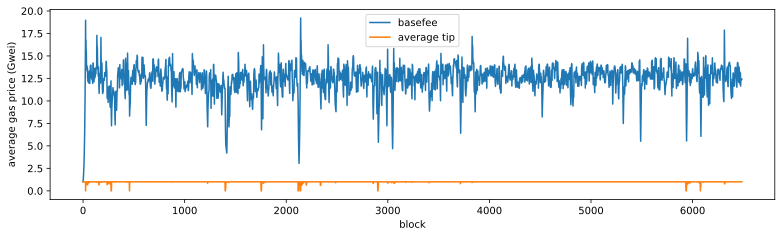

In [5]:
# f = plt.figure()
df.plot("block", ["basefee", "blk_avg_tip"], label=["basefee", "average tip"], figsize=(13,3.5))
plt.ylabel("average gas price (Gwei)")
plt.savefig('../results/exp1_1.pdf')

<AxesSubplot:xlabel='block'>

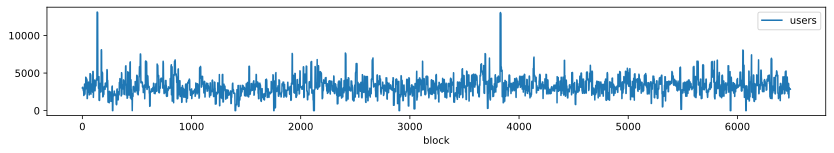

In [6]:
# f = plt.figure()
df.plot("block", ["users"], figsize=(14,2))
# plt.savefig('../results/exp1_1.pdf')

Real data: average gas price, before EIP-1559

In [ ]:
mean = [18, 32, 17, 22, 18, 17, 30, 18, 15, 15, 16, 20, 17, 15, 22, 26, 18, 7, 28, 16, 17, 13, 15, 20, 21, 18, 24, 19, 19, 17, 17, 20, 12, 23, 22, 19, 15, 21, 15, 20, 18, 16, 17, 20, 12, 20, 16, 18, 18, 16, 15, 18, 16, 3, 17, 15, 19, 14, 20, 27, 21, 14, 14, 23, 21, 14, 13, 21, 16, 19, 16, 17, 16, 13, 21, 18, 18, 12, 24, 18, 14, 16, 14, 15, 16, 28, 30, 24, 17, 14, 19, 17, 19, 18, 25, 16, 23, 22, 18, 19, 13, 16, 22, 19, 25, 14, 19, 13, 28, 15, 14, 15, 19, 19, 18, 26, 25, 18, 13, 16, 19, 23, 18, 25, 19, 23, 14, 20, 31, 19, 17, 14, 23, 17, 22, 17, 24, 15, 15, 18, 20, 17, 25, 15, 19, 22, 16, 15, 22, 22, 19, 32, 15, 1, 26, 27, 33, 20, 28, 34, 16, 22, 11, 22, 25, 23, 18, 15, 17, 21, 20, 19, 19, 20, 19, 22, 22, 18, 16, 23, 20, 20, 9, 17, 15, 14, 17, 18, 22, 5, 19, 30, 13, 17, 21, 19, 17, 22, 21, 12, 15, 26, 13, 26, 19, 28, 17, 17, 17, 14, 27, 18, 14, 21, 14, 19, 23, 24, 27, 15, 22, 14, 13, 14, 21, 20, 31, 20, 19, 18, 12, 14, 19, 20, 29, 23, 28, 17, 14, 16, 13, 17, 13, 15, 20, 18, 16, 27, 25, 22, 28, 24, 26, 11, 20, 14, 14, 15, 17, 22, 25, 15, 14, 24, 20, 13, 16, 21, 9, 28, 24, 15, 13, 22, 19, 16, 18, 27, 22, 22, 17, 14, 17, 18, 12, 24, 15, 15, 17, 20, 18, 25, 18, 19, 21, 15, 18, 17, 17, 16, 12, 22, 29, 13, 30, 12, 14, 22, 23, 18, 18, 13, 13, 17, 12, 21, 22, 27, 29, 16, 16, 17, 19, 17, 26, 21, 21, 14, 21, 19, 23, 12, 17, 15, 24, 24, 23, 19, 12, 23, 31, 20, 16, 28, 20, 25, 14, 27, 16, 24, 18, 40, 9, 25, 21, 13, 15, 23, 23, 19, 20, 18, 18, 22, 20, 25, 14, 17, 16, 24, 7, 16, 28, 20, 24, 16, 18, 24, 12, 30, 23, 18, 17, 14, 24, 14, 22, 25, 26, 16, 23, 13, 16, 15, 40, 14, 16, 18, 21, 15, 19, 27, 20, 15, 13, 19, 21, 27, 12, 15, 18, 15, 26, 22, 21, 13, 14, 21, 14, 17, 11, 21, 15, 12, 24, 22, 17, 16, 20, 12, 23, 12, 23, 24, 22, 13, 19, 12, 18, 15, 13, 18, 15, 14, 13, 18, 20, 17, 18, 15, 19, 25, 13, 27, 22, 23, 21, 21, 16, 25, 30, 19, 31, 15, 16, 20, 23, 14, 26, 17, 23, 20, 15, 13, 28, 17, 17, 16, 23, 12, 15, 14, 45, 15, 26, 19, 15, 17, 12, 18, 24, 18, 19, 18, 20, 20, 16, 26, 13, 6, 17, 26, 17, 27, 20, 17, 23, 18, 28, 25, 18, 14, 12, 14, 18, 20, 23, 22, 16, 78, 21, 18, 15, 18, 20, 22, 23, 21, 17, 19, 19, 22, 18, 19, 16, 15, 14, 22, 14, 17, 18, 20, 19, 14, 8, 15, 18, 18, 19, 21, 17, 23, 16, 22, 18, 15, 22, 15, 25, 21, 10, 16, 19, 35, 14, 5, 24, 24, 25, 20, 16, 17, 22, 24, 17, 22, 16, 19, 18, 15, 11, 12, 14, 19, 12, 16, 13, 17, 17, 18, 16, 17, 15, 13, 16, 5, 13, 24, 13, 26, 30, 12, 17, 19, 14, 15, 15, 10, 25, 23, 21, 17, 17, 17, 24, 9, 17, 17, 17, 21, 27, 14, 21, 14, 20, 12, 17, 17, 12, 20, 27, 21, 20, 20, 22, 13, 21, 19, 4, 17, 28, 19, 10, 25, 13, 27, 14, 19, 21, 21, 20, 13, 21, 24, 22, 17, 18, 21, 16, 13, 12, 15, 21, 14, 12, 24, 21, 17, 13, 20, 18, 14, 10, 22, 17, 12, 19, 14, 21, 4, 13, 17, 21, 14, 21, 13, 16, 23, 20, 14, 14, 14, 13, 11, 21, 21, 15, 18, 11, 11, 12, 13, 17, 16, 16, 19, 4, 19, 26, 13, 15, 11, 15, 14, 18, 13, 15, 12, 5, 13, 20, 24, 16, 15, 12, 19, 18, 16, 10, 20, 22, 15, 21, 16, 18, 11, 30, 11, 23, 17, 13, 27, 13, 19, 22, 16, 13, 12, 24, 21, 14, 20, 21, 12, 13, 14, 13, 14, 15, 21, 9, 23, 13, 26, 18, 28, 22, 13, 28, 18, 23, 33, 20, 20, 12, 17, 13, 19, 18, 20, 30, 13, 19, 18, 21, 19, 17, 41, 14, 24, 14, 10, 13, 13, 13, 18, 28, 14, 12, 21, 19, 12, 21, 12, 20, 18, 14, 17, 17, 17, 11, 20, 18, 19, 19, 15, 16, 23, 14, 19, 19, 21, 27, 26, 17, 21, 24, 16, 13, 22, 19, 14, 51, 13, 22, 14, 24, 25, 20, 15, 14, 16, 12, 11, 18, 20, 34, 16, 24, 23, 23, 19, 15, 26, 14, 15, 25, 20, 13, 22, 13, 17, 12, 16, 23, 11, 19, 11, 20, 9, 19, 23, 18, 20, 18, 24, 13, 23, 15, 25, 18, 19, 19, 28, 21, 16, 19, 20, 18, 14, 10, 11, 10, 18, 16, 26, 16, 25, 16, 24, 16, 18, 14, 18, 17, 16, 19, 15, 22, 13, 18, 22, 13, 6, 14, 37, 14, 17, 13, 56, 21, 15, 42, 18, 16, 13, 13, 34, 14, 20, 20, 20, 12, 19, 13, 21, 15, 15, 13, 19, 19, 23, 23, 18, 15, 3, 19, 12, 17, 15, 8, 25, 24, 16, 22, 17, 13, 14, 13, 26, 19, 13, 19, 19, 16, 22, 21, 17, 15, 22, 24, 16, 14, 18, 15, 17, 18, 26, 14, 46, 17, 17, 26, 17, 12, 26, 21, 18, 19, 28, 15, 10, 21, 18, 17, 15, 24, 11, 14, 19, 23, 17, 14, 22, 16, 15, 11, 21, 17, 12, 19, 19, 11, 19, 15, 17, 19, 20, 16, 17, 17, 14, 16, 21, 16, 22, 11, 21, 14, 17, 35, 22, 12, 19, 17, 18, 11, 16, 15, 14, 22, 17, 13, 16, 13, 18, 12, 12, 21, 20, 11, 21, 15, 21, 22, 22, 11, 20, 21, 24, 11, 21, 15, 18, 22, 21, 19, 16, 21, 14, 11, 12, 28, 17, 18, 13, 17, 11, 16, 18, 17, 17, 18, 10, 17, 15, 16, 19, 21, 20, 15, 22, 24, 29, 18, 20, 18, 16, 20, 23, 16, 18, 26, 14, 23, 24, 17, 24, 14, 23, 15, 20, 21, 21, 14, 23, 22, 14, 20, 14, 18, 18, 21, 16, 20, 20, 23, 26, 14, 16, 14, 18, 16, 22, 16, 20, 19, 16, 19, 13, 24, 15, 26, 17, 18, 16, 13, 12, 26, 24, 21, 29, 22, 14, 14, 13, 15, 18, 26, 22, 15, 20, 19, 12, 20, 16, 19, 13, 16, 14, 15, 20, 13, 18, 18, 19, 22, 14, 17, 19, 21, 23, 18, 15, 18, 13, 13, 14, 22, 15, 17, 12, 15, 11, 14, 13, 13, 23, 16, 14, 19, 15, 13, 12, 16, 10, 12, 15, 21, 14, 19, 11, 28, 15, 16, 13, 12, 17, 15, 14, 19, 12, 17, 17, 15, 12, 32, 15, 105, 28, 25, 26, 20, 28, 18, 33, 15, 12, 13, 19, 15, 18, 19, 11, 19, 16, 18, 12, 11, 21, 17, 16, 17, 22, 15, 19, 20, 26, 19, 25, 22, 26, 17, 17, 14, 16, 15, 13, 16, 16, 19, 14, 11, 26, 12, 15, 12, 13, 21, 18, 19, 13, 15, 13, 19, 21, 13, 15, 19, 13, 10, 18, 24, 20, 22, 28, 13, 13, 20, 37, 20, 24, 16, 27, 14, 15, 28, 21, 13, 19, 22, 19, 20, 17, 12, 25, 23, 18, 14, 10, 23, 14, 23, 22, 16, 21, 28, 15, 26, 9, 21, 34, 28, 17, 17, 19, 26, 14, 24, 15, 16, 19, 32, 20, 17, 16, 19, 15, 16, 21, 13, 26, 16, 17, 23, 21, 23, 16, 24, 19, 31, 24, 31, 33, 25, 11, 20, 25, 27, 14, 15, 16, 17, 11, 17, 14, 19, 22, 14, 14, 11, 24, 12, 16, 16, 9, 18, 17, 22, 15, 11, 25, 18, 20, 16, 30, 16, 15, 17, 18, 18, 11, 14, 21, 18, 19, 13, 16, 21, 14, 5, 23, 13, 18, 18, 13, 11, 22, 16, 12, 12, 11, 23, 10, 18, 20, 12, 23, 14, 20, 15, 11, 13, 21, 11, 26, 18, 12, 17, 11, 11, 13, 20, 16, 19, 17, 11, 24, 19, 13, 13, 15, 14, 15, 25, 11, 20, 11, 15, 12, 15, 20, 11, 18, 14, 19, 12, 24, 12, 16, 22, 16, 20, 14, 21, 21, 19, 10, 13, 20, 12, 11, 24, 25, 13, 15, 16, 18, 11, 13, 22, 13, 26, 4, 15, 15, 12, 20, 9, 14, 15, 11, 12, 10, 12, 13, 27, 16, 16, 18, 16, 16, 10, 24, 19, 12, 12, 24, 22, 11, 15, 14, 10, 22, 12, 25, 15, 21, 13, 13, 12, 13, 10, 18, 11, 14, 10, 21, 14, 13, 11, 12, 19, 11, 10, 12, 16, 10, 19, 17, 10, 25, 15, 20, 19, 21, 20, 15, 15, 12, 25, 15, 26, 11, 22, 25, 12, 19, 14, 19, 24, 11, 25, 10, 17, 19, 53, 23, 20, 12, 13, 21, 18, 16, 24, 17, 23, 22, 12, 17, 14, 18, 15, 26, 19, 11, 13, 18, 18, 20, 11, 13, 10, 11, 19, 22, 11, 27, 16, 20, 7, 15, 11, 25, 14, 15, 12, 15, 14, 10, 20, 13, 24, 13, 22, 14, 17, 20, 16, 12, 12, 15, 12, 16, 15, 39, 10, 15, 16, 14, 11, 16, 10, 22, 18, 13, 25, 19, 22, 18, 29, 12, 16, 19, 16, 16, 11, 11, 17, 12, 12, 16, 13, 12, 27, 18, 12, 18, 11, 16, 6, 18, 25, 12, 20, 28, 14, 12, 10, 16, 12, 13, 11, 24, 15, 18, 25, 13, 35, 16, 16, 21, 14, 15, 13, 15, 11, 15, 21, 30, 15, 10, 1, 12, 18, 11, 18, 14, 27, 28, 16, 11, 27, 12, 20, 18, 20, 19, 32, 17, 12, 20, 17, 19, 22, 21, 15, 23, 15, 26, 12, 16, 19, 14, 16, 12, 11, 14, 11, 24, 15, 28, 24, 13, 19, 20, 20, 23, 14, 14, 13, 15, 16, 18, 12, 12, 21, 13, 15, 28, 14, 16, 19, 17, 15, 14, 24, 20, 14, 63, 20, 11, 15, 13, 12, 21, 12, 10, 25, 14, 18, 14, 22, 14, 12, 16, 15, 15, 21, 20, 16, 16, 13, 16, 22, 21, 19, 33, 13, 15, 28, 23, 24, 13, 15, 49, 15, 19, 22, 22, 12, 19, 11, 17, 17, 12, 19, 14, 18, 21, 27, 19, 16, 19, 24, 22, 27, 17, 26, 12, 14, 18, 19, 13, 15, 11, 22, 18, 20, 28, 26, 18, 17, 14, 19, 19, 16, 18, 10, 18, 14, 21, 30, 14, 20, 20, 17, 38, 14, 24, 18, 14, 17, 17, 16, 15, 10, 20, 17, 25, 15, 30, 11, 17, 13, 19, 21, 11, 18, 14, 16, 15, 1, 11, 22, 26, 15, 13, 12, 28, 18, 22, 11, 12, 22, 13, 21, 13, 21, 21, 14, 12, 25, 10, 17, 17, 17, 19, 14, 18, 22, 12, 24, 11, 12, 16, 14, 18, 23, 11, 10, 13, 16, 23, 17, 18, 12, 18, 15, 15, 17, 16, 20, 20, 13, 19, 12, 21, 16, 18, 14, 11, 12, 18, 14, 21, 11, 16, 15, 17, 10, 16, 24, 11, 21, 22, 13, 17, 12, 14, 20, 14, 10, 14, 13, 18, 20, 29, 15, 14, 20, 20, 21, 12, 20, 11, 26, 14, 11, 24, 16, 22, 29, 19, 11, 11, 18, 19, 12, 27, 21, 12, 18, 2, 15, 16, 16, 24, 17, 12, 14, 29, 20, 22, 20, 11, 19, 18, 26, 19, 16, 20, 20, 33, 12, 19, 6, 12, 15, 15, 13, 12, 7, 12, 12, 20, 12, 27, 19, 6, 17, 17, 27, 14, 12, 9, 23, 15, 12, 53, 17, 13, 8, 4, 19, 16, 12, 12, 22, 19, 11, 16, 13, 13, 22, 14, 11, 19, 16, 18, 21, 11, 15, 13, 14, 26, 16, 17, 12, 4, 20, 20, 17, 10, 17, 8, 17, 11, 22, 14, 25, 15, 4, 12, 12, 10, 24, 19, 23, 17, 18, 13, 12, 11, 16, 13, 14, 21, 12, 15, 12, 12, 11, 21, 16, 24, 4, 20, 12, 16, 6, 10, 15, 14, 15, 11, 15, 16, 22, 17, 18, 13, 12, 13, 20, 15, 13, 12, 16, 12, 12, 12, 16, 16, 16, 31, 26, 11, 12, 13, 15, 17, 17, 15, 11, 18, 20, 12, 16, 13, 16, 9, 15, 14, 29, 11, 16, 20, 8, 24, 17, 16, 13, 28, 17, 16, 22, 12, 16, 20, 17, 15, 20, 10, 17, 16, 22, 27, 14, 24, 16, 13, 18, 15, 20, 28, 18, 30, 16, 21, 14, 15, 23, 14, 17, 17, 16, 13, 23, 14, 11, 23, 12, 17, 21, 17, 12, 12, 15, 19, 21, 12, 12, 22, 15, 23, 15, 11, 23, 14, 20, 24, 18, 13, 12, 6, 18, 18, 13, 15, 28, 13, 23, 20, 30, 14, 19, 14, 18, 14, 20, 18, 11, 12, 22, 12, 12, 19, 13, 15, 14, 6, 23, 22, 22, 14, 11, 15, 14, 16, 12, 12, 19, 11, 17, 15, 22, 24, 26, 15, 26, 22, 13, 15, 12, 21, 15, 17, 21, 18, 23, 15, 18, 20, 13, 27, 15, 13, 14, 32, 15, 21, 21, 18, 19, 12, 16, 11, 26, 14, 12, 25, 16, 25, 11, 9, 11, 13, 9, 19, 23, 17, 21, 16, 24, 12, 13, 17, 29, 12, 18, 14, 25, 19, 12, 21, 16, 19, 19, 11, 16, 20, 14, 21, 23, 13, 14, 22, 16, 21, 20, 17, 15, 24, 12, 9, 13, 14, 12, 14, 23, 20, 18, 13, 16, 23, 20, 21, 20, 17, 26, 13, 14, 47, 12, 18, 15, 15, 22, 10, 18, 11, 21, 14, 15, 18, 86, 10, 25, 13, 13, 12, 37, 13, 29, 13, 18, 16, 13, 21, 16, 16, 13, 14, 14, 3, 13, 21, 13, 6, 12, 20, 16, 11, 11, 24, 19, 18, 19, 10, 12, 15, 17, 17, 13, 18, 13, 16, 16, 14, 27, 14, 17, 19, 26, 16, 28, 22, 14, 20, 17, 38, 15, 70, 11, 20, 25, 14, 21, 25, 19, 18, 30, 13, 15, 15, 13, 11, 16, 16, 18, 22, 13, 18, 17, 10, 16, 15, 15, 12, 17, 21, 8, 16, 14, 18, 32, 22, 10, 10, 15, 22, 22, 35, 14, 22, 12, 17, 11, 21, 21, 13, 19, 18, 10, 16, 16, 18, 11, 22, 33, 16, 25, 24, 21, 13, 15, 30, 11, 22, 16, 18, 30, 22, 12, 13, 11, 17, 11, 21, 12, 10, 21, 11, 13, 15, 18, 14, 11, 18, 30, 20, 24, 14, 15, 17, 22, 20, 19, 14, 12, 15, 14, 12, 15, 18, 22, 19, 12, 13, 18, 13, 11, 17, 23, 15, 17, 25, 13, 21, 12, 9, 23, 17, 22, 32, 19, 12, 26, 17, 9, 23, 19, 14, 14, 14, 18, 14, 16, 12, 16, 21, 21, 17, 22, 23, 15, 19, 22, 12, 6, 14, 13, 21, 19, 15, 11, 21, 21, 25, 9, 24, 13, 19, 29, 16, 13, 16, 17, 14, 16, 13, 20, 21, 14, 21, 21, 17, 13, 11, 13, 20, 18, 19, 20, 25, 15, 34, 8, 25, 19, 21, 16, 13, 14, 24, 15, 16, 12, 26, 17, 12, 12, 18, 14, 13, 17, 16, 12, 17, 22, 18, 22, 12, 16, 14, 22, 19, 22, 11, 13, 14, 26, 14, 16, 19, 17, 15, 13, 18, 15, 19, 24, 17, 14, 16, 13, 18, 14, 19, 11, 15, 17, 11, 13, 15, 11, 19, 12, 18, 17, 15, 13, 15, 19, 17, 19, 14, 40, 23, 17, 13, 13, 9, 12, 12, 13, 19, 12, 26, 14, 14, 24, 19, 22, 25, 22, 11, 12, 22, 17, 18, 15, 18, 21, 13, 12, 14, 22, 10, 22, 18, 25, 25, 23, 19, 13, 14, 24, 13, 17, 16, 16, 31, 17, 13, 15, 26, 15, 21, 20, 12, 14, 12, 12, 26, 17, 12, 18, 14, 18, 10, 16, 17, 12, 16, 10, 16, 11, 13, 18, 17, 16, 17, 23, 14, 15, 14, 11, 15, 17, 12, 12, 18, 14, 51, 17, 20, 18, 20, 11, 15, 16, 16, 19, 21, 14, 25, 15, 17, 15, 13, 64, 14, 16, 22, 19, 10, 40, 14, 21, 21, 16, 12, 11, 11, 24, 17, 18, 17, 13, 23, 11, 13, 18, 19, 23, 20, 17, 22, 19, 15, 13, 12, 17, 21, 11, 14, 16, 11, 14, 17, 14, 21, 10, 14, 11, 27, 18, 16, 24, 17, 17, 22, 16, 19, 12, 14, 17, 22, 14, 20, 11, 19, 15, 29, 6, 11, 18, 17, 17, 17, 10, 20, 12, 12, 17, 15, 20, 23, 11, 17, 18, 21, 17, 26, 13, 19, 18, 20, 14, 27, 19, 19, 19, 16, 19, 19, 23, 17, 14, 19, 19, 18, 15, 21, 20, 23, 12, 19, 22, 22, 24, 24, 16, 16, 14, 22, 11, 28, 17, 19, 15, 20, 24, 20, 19, 27, 21, 21, 15, 19, 19, 14, 19, 21, 20, 18, 18, 14, 27, 22, 16, 17, 24, 14, 24, 15, 14, 16, 24, 20, 21, 16, 15, 23, 17, 12, 14, 16, 14, 23, 14, 16, 15, 30, 17, 27, 30, 28, 14, 24, 20, 15, 21, 13, 14, 10, 13, 11, 12, 21, 13, 23, 13, 13, 26, 21, 19, 10, 10, 11, 12, 12, 15, 12, 13, 13, 16, 16, 18, 12, 13, 11, 18, 22, 13, 21, 11, 20, 22, 17, 16, 13, 25, 25, 15, 22, 14, 21, 24, 13, 19, 19, 12, 16, 15, 13, 19, 16, 11, 12, 15, 12, 15, 21, 12, 14, 12, 15, 22, 12, 12, 20, 15, 22, 13, 17, 13, 11, 19, 18, 12, 11, 11, 19, 14, 12, 11, 20, 13, 16, 11, 16, 13, 17, 15, 28, 16, 18, 21, 13, 16, 22, 13, 18, 19, 12, 16, 17, 17, 20, 22, 14, 11, 23, 12, 17, 12, 18, 18, 18, 26, 11, 17, 15, 22, 14, 20, 18, 21, 14, 16, 13, 16, 22, 17, 21, 23, 24, 16, 19, 26, 12, 20, 17, 26, 16, 11, 18, 20, 18, 11, 26, 15, 19, 21, 9, 22, 15, 17, 13, 16, 14, 14, 19, 16, 25, 16, 13, 18, 13, 28, 17, 13, 15, 12, 16, 13, 21, 13, 18, 20, 18, 20, 12, 22, 16, 15, 16, 15, 17, 19, 28, 22, 11, 15, 15, 167, 14, 13, 19, 45, 24, 15, 13, 14, 24, 41, 20, 16, 13, 29, 20, 20, 22, 12, 14, 27, 16, 11, 25, 15, 15, 23, 16, 15, 12, 13, 22, 14, 15, 18, 16, 12, 12, 17, 21, 18, 18, 14, 11, 20, 25, 21, 22, 15, 21, 14, 14, 24, 14, 12, 23, 14, 7, 22, 12, 11, 26, 11, 22, 23, 20, 17, 21, 11, 12, 32, 19, 13, 15, 22, 13, 19, 13, 12, 15, 15, 15, 15, 11, 31, 17, 19, 13, 12, 20, 20, 11, 18, 18, 12, 17, 11, 24, 22, 12, 25, 12, 14, 13, 23, 23, 19, 23, 13, 14, 14, 19, 21, 12, 15, 13, 23, 16, 11, 23, 19, 13, 15, 19, 14, 19, 12, 18, 22, 19, 20, 11, 15, 14, 15, 22, 20, 16, 18, 17, 12, 15, 20, 24, 12, 20, 15, 18, 16, 17, 20, 14, 13, 18, 21, 19, 28, 20, 17, 12, 18, 24, 13, 16, 15, 12, 20, 26, 13, 10, 17, 15, 15, 22, 20, 22, 22, 18, 12, 13, 20, 17, 18, 20, 19, 14, 13, 19, 11, 18, 17, 20, 13, 11, 16, 15, 11, 24, 26, 28, 3, 14, 16, 11, 11, 15, 17, 16, 21, 20, 28, 16, 18, 14, 26, 14, 27, 25, 21, 14, 11, 14, 18, 21, 14, 24, 13, 22, 23, 14, 13, 13, 14, 20, 20, 13, 18, 22, 20, 12, 31, 14, 14, 18, 14, 20, 25, 18, 23, 18, 14, 12, 24, 21, 19, 8, 17, 16, 16, 16, 10, 18, 35, 16, 16, 14, 26, 13, 17, 15, 15, 15, 15, 18, 19, 24, 22, 17, 11, 19, 16, 21, 18, 12, 20, 26, 16, 17, 28, 18, 21, 23, 17, 24, 17, 11, 14, 19, 24, 12, 24, 20, 25, 17, 13, 13, 15, 11, 18, 12, 13, 20, 14, 15, 22, 16, 17, 16, 17, 25, 23, 16, 19, 24, 12, 23, 13, 17, 17, 29, 21, 16, 17, 21, 21, 18, 19, 14, 17, 3, 25, 18, 19, 15, 12, 10, 14, 15, 19, 20, 11, 12, 18, 22, 37, 54, 23, 24, 16, 17, 13, 20, 19, 28, 16, 19, 14, 13, 20, 24, 14, 17, 13, 18, 16, 18, 13, 21, 22, 14, 14, 18, 19, 12, 18, 17, 23, 21, 22, 19, 25, 18, 26, 23, 22, 13, 47, 15, 21, 18, 15, 24, 12, 15, 10, 13, 20, 27, 15, 16, 37, 17, 20, 18, 24, 26, 24, 17, 14, 29, 23, 18, 13, 23, 20, 14, 12, 19, 18, 21, 24, 17, 14, 14, 20, 10, 17, 23, 27, 15, 15, 18, 13, 20, 10, 19, 21, 16, 33, 18, 31, 15, 17, 16, 23, 18, 24, 16, 24, 17, 16, 25, 32, 14, 18, 23, 14, 12, 15, 19, 26, 16, 16, 26, 21, 18, 16, 18, 25, 15, 14, 17, 14, 15, 14, 21, 23, 19, 17, 19, 22, 19, 16, 20, 26, 16, 19, 22, 16, 11, 14, 24, 22, 12, 19, 18, 12, 16, 15, 18, 14, 19, 18, 20, 18, 12, 18, 27, 13, 19, 23, 21, 14, 21, 13, 22, 17, 17, 27, 19, 19, 23, 21, 8, 20, 22, 16, 16, 25, 19, 14, 17, 17, 27, 16, 14, 20, 14, 14, 11, 17, 21, 23, 23, 15, 34, 20, 14, 18, 14, 18, 19, 14, 13, 10, 20, 20, 25, 29, 23, 15, 20, 19, 14, 20, 53, 19, 31, 16, 21, 19, 17, 24, 17, 17, 16, 22, 14, 21, 22, 11, 14, 16, 19, 31, 24, 18, 14, 8, 24, 20, 13, 19, 11, 16, 20, 18, 21, 18, 21, 16, 13, 26, 17, 17, 25, 15, 23, 21, 22, 21, 18, 25, 17, 21, 20, 17, 16, 26, 14, 37, 16, 20, 31, 16, 19, 16, 21, 25, 19, 22, 27, 30, 19, 21, 16, 23, 15, 72, 34, 31, 19, 16, 14, 14, 30, 20, 19, 12, 16, 16, 36, 19, 16, 20, 12, 16, 15, 14, 19, 20, 23, 18, 23, 22, 16, 18, 13, 16, 24, 11, 25, 24, 12, 20, 27, 24, 18, 16, 20, 24, 19, 22, 17, 14, 22, 20, 16, 23, 27, 29, 12, 16, 13, 17, 20, 19, 20, 18, 14, 18, 25, 17, 17, 41, 17, 14, 14, 14, 21, 22, 17, 13, 21, 22, 22, 15, 26, 12, 17, 23, 17, 17, 17, 24, 21, 13, 15, 23, 14, 24, 16, 28, 26, 22, 27, 12, 13, 19, 24, 26, 15, 26, 29, 16, 28, 18, 26, 25, 24, 16, 18, 4, 16, 14, 13, 16, 28, 23, 13, 16, 20, 20, 13, 16, 13, 15, 20, 21, 20, 26, 11, 13, 7, 14, 17, 12, 15, 23, 15, 14, 21, 22, 16, 18, 22, 23, 6, 16, 28, 21, 13, 14, 20, 16, 19, 16, 27, 16, 17, 21, 14, 22, 20, 14, 13, 15, 23, 18, 14, 17, 18, 29, 16, 12, 14, 14, 13, 14, 26, 23, 17, 25, 16, 32, 16, 23, 23, 16, 12, 23, 17, 25, 20, 27, 13, 14, 33, 19, 23, 23, 15, 20, 23, 18, 18, 27, 23, 14, 22, 26, 15, 25, 16, 12, 22, 21, 22, 22, 17, 15, 15, 14, 18, 13, 12, 25, 20, 15, 21, 32, 28, 25, 42, 35, 30, 17, 17, 25, 10, 21, 17, 23, 20, 15, 28, 16, 26, 15, 21, 22, 21, 25, 27, 25, 16, 15, 17, 22, 19, 25, 12, 16, 17, 22, 25, 22, 34, 27, 21, 19, 16, 38, 19, 35, 18, 23, 18, 17, 27, 21, 19, 23, 15, 15, 22, 30, 27, 17, 20, 22, 19, 18, 16, 24, 21, 19, 18, 24, 12, 25, 13, 18, 27, 20, 16, 14, 22, 16, 14, 18, 14, 17, 14, 14, 21, 20, 20, 14, 22, 15, 19, 13, 18, 28, 24, 21, 17, 28, 19, 17, 27, 23, 20, 13, 26, 25, 21, 20, 16, 29, 20, 13, 15, 14, 12, 21, 20, 23, 14, 17, 17, 26, 22, 18, 15, 7, 16, 21, 17, 17, 20, 24, 20, 14, 26, 20, 18, 21, 21, 23, 12, 21, 15, 12, 22, 20, 17, 22, 19, 19, 20, 21, 16, 17, 27, 25, 14, 27, 22, 11, 18, 23, 22, 24, 20, 22, 20, 26, 23, 16, 20, 17, 17, 20, 16, 23, 22, 24, 17, 15, 32, 23, 18, 21, 18, 16, 27, 12, 38, 28, 25, 17, 21, 21, 13, 20, 27, 28, 34, 23, 16, 20, 15, 16, 14, 17, 21, 31, 13, 14, 22, 12, 24, 17, 16, 16, 26, 29, 15, 18, 21, 15, 24, 19, 17, 22, 18, 23, 15, 15, 28, 18, 24, 30, 22, 16, 25, 30, 18, 14, 33, 34, 19, 37, 18, 20, 23, 20, 19, 26, 16, 32, 26, 28, 29, 27, 25, 19, 28, 21, 26, 27, 24, 20, 20, 22, 23, 23, 20, 19, 33, 25, 20, 28, 21, 30, 21, 17, 24, 23, 21, 18, 17, 18, 18, 15, 22, 23, 21, 22, 24, 19, 17, 22, 22, 21, 24, 24, 18, 20, 24, 15, 16, 13, 18, 15, 13, 12, 23, 25, 17, 17, 24, 14, 21, 23, 24, 14, 19, 21, 27, 16, 29, 43, 18, 19, 18, 16, 25, 15, 28, 25, 16, 22, 23, 26, 18, 14, 40, 32, 23, 20, 33, 47, 20, 15, 23, 16, 13, 13, 16, 21, 45, 24, 27, 28, 21, 50, 36, 17, 15, 24, 14, 24, 17, 34, 31, 40, 40, 19, 17, 20, 26, 22, 32, 23, 23, 15, 18, 20, 19, 25, 33, 24, 18, 16, 16, 20, 21, 13, 20, 28, 21, 23, 14, 20, 27, 20, 24, 23, 19, 15, 14, 28, 22, 21, 16, 17, 19, 24, 44, 54, 29, 33, 34, 39, 33, 47, 36, 23, 23, 30, 25, 24, 28, 26, 32, 31, 25, 27, 36, 28, 26, 25, 22, 34, 30, 24, 23, 24, 30, 23, 23, 20, 19, 47, 25, 41, 24, 44, 28, 21, 26, 27, 28, 19, 21, 21, 17, 26, 19, 21, 18, 25, 16, 30, 16, 25, 20, 28, 19, 29, 28, 31, 26, 18, 18, 19, 14, 15, 26, 21, 28, 17, 27, 25, 29, 23, 31, 20, 16, 17, 25, 23, 18, 16, 25, 22, 20, 20, 8, 24, 16, 18, 20, 26, 22, 32, 21, 21, 24, 27, 25, 20, 20, 24, 18, 34, 29, 16, 15, 16, 19, 20, 13, 20, 27, 25, 20, 20, 23, 33, 13, 26, 18, 23, 21, 21, 25, 17, 22, 19, 23, 36, 29, 19, 20, 24, 13, 21, 25, 17, 23, 13, 26, 29, 19, 19, 20, 14, 28, 21, 15, 36, 24, 13, 26, 18, 23, 22, 21, 18, 19, 25, 27, 22, 20, 18, 27, 19, 15, 19, 24, 11, 17, 27, 30, 23, 21, 25, 27, 25, 23, 28, 18, 22, 22, 17, 43, 16, 26, 35, 21, 29, 15, 23, 14, 30, 23, 13, 26, 17, 24, 24, 13, 27, 20, 20, 19, 24, 64, 19, 27, 33, 27, 16, 24, 85, 29, 22, 21, 25, 26, 38, 22, 18, 44, 22, 30, 30, 17, 8, 24, 27, 18, 30, 26, 23, 18, 26, 22, 16, 32, 25, 22, 38, 18, 18, 28, 16, 20, 27, 18, 28, 22, 24, 22, 18, 20, 18, 24, 23, 19, 27, 22, 24, 16, 20, 24, 26, 22, 15, 29, 17, 22, 17, 18, 20, 40, 14, 24, 14, 20, 21, 31, 22, 17, 14, 35, 23, 23, 22, 19, 25, 30, 27, 13, 21, 31, 11, 24, 29, 15, 23, 17, 22, 18, 17, 17, 11, 20, 25, 16, 24, 32, 21, 29, 30, 27, 20, 22, 21, 14, 20, 29, 17, 13, 29, 18, 27, 21, 26, 16, 24, 24, 28, 19, 5, 19, 19, 15, 15, 16, 20, 106, 18, 15, 14, 21, 30, 17, 15, 21, 19, 118, 14, 17, 20, 51, 23, 19, 21, 25, 78, 20, 13, 22, 19, 83, 36, 14, 29, 26, 22, 30, 30, 7, 73, 21, 22, 36, 10, 22, 15, 25, 17, 25, 24, 13, 23, 20, 39, 24, 11, 63, 31, 22, 21, 18, 45, 17, 14, 15, 30, 21, 54, 21, 12, 22, 24, 25, 25, 18, 16, 13, 16, 13, 19, 14, 26, 22, 14, 17, 17, 22, 23, 21, 35, 21, 21, 18, 19, 23, 14, 19, 18, 24, 13, 14, 28, 20, 19, 18, 17, 41, 17, 21, 22, 25, 34, 13, 15, 19, 24, 29, 19, 24, 18, 21, 16, 23, 13, 30, 37, 18, 25, 41, 23, 22, 23, 22, 23, 17, 16, 13, 20, 16, 24, 13, 21, 13, 14, 14, 18, 18, 12, 12, 13, 22, 22, 21, 18, 19, 23, 17, 24, 29, 48, 23, 16, 15, 16, 23, 17, 21, 10, 17, 16, 16, 20, 20, 19, 15, 18, 18, 19, 13, 22, 14, 30, 24, 20, 15, 18, 14, 22, 21, 15, 20, 11, 12, 26, 25, 21, 13, 16, 18, 22, 43, 11, 17, 19, 17, 14, 19, 13, 19, 13, 24, 22, 27, 22, 37, 26, 17, 19, 23, 15, 24, 15, 20, 14, 27, 33, 19, 21, 21, 17, 19, 21, 23, 14, 19, 20, 14, 36, 20, 21, 23, 17, 16, 19, 29, 31, 20, 17, 31, 43, 64, 16, 23, 14, 17, 19, 20, 16, 14, 19, 15, 17, 14, 25, 16, 16, 14, 15, 14, 13, 15, 11, 20, 17, 12, 22, 17, 14, 14, 15, 22, 13, 12, 14, 26, 18, 29, 15, 16, 17, 16, 32, 19, 14, 16, 29, 22, 15, 30, 41, 21, 15, 35, 17, 14, 86, 25, 36, 66, 28, 31, 16, 16, 18, 16, 9, 72, 14, 14, 18, 51, 27, 23, 28, 22, 18, 12, 37, 15, 19, 16, 37, 13, 26, 28, 13, 23, 16, 43, 13, 14, 24, 22, 16, 7, 23, 17, 29, 22, 10, 15, 39, 13, 26, 20, 15, 37, 20, 11, 20, 25, 33, 29, 14, 12, 75, 16, 22, 12, 58, 14, 14, 39, 13, 43, 19, 26, 26, 28, 15, 14, 26, 15, 24, 21, 20, 24, 19, 13, 29, 23, 23, 41, 19, 53, 17, 18, 53, 12, 24, 83, 19, 32, 25, 16, 36, 15, 39, 24, 14, 20, 16, 25, 26, 19, 35, 13, 25, 21, 28, 23, 21, 14, 15, 21, 21, 13, 31, 13, 30, 16, 32, 16, 15, 25, 17, 13, 25, 21, 10, 19, 29, 13, 34, 17, 12, 23, 37, 21, 16, 32, 19, 12, 12, 31, 20, 12, 22, 15, 12, 17, 24, 10, 18, 25, 21, 17, 16, 25, 15, 22, 14, 20, 18, 20, 14, 20, 33, 26, 25, 16, 42, 30, 25, 23, 12, 23, 27, 11, 23, 24, 43, 21, 25, 24, 25, 26, 15, 21, 21, 14, 14, 31, 24, 23, 13, 24, 19, 30, 14, 22, 22, 18, 20, 30, 24, 21, 19, 18, 14, 28, 13, 11, 19, 15, 18, 23, 28, 14, 13, 28, 22, 18, 26, 22, 22, 17, 16, 14, 28, 17, 20, 15, 24, 25, 19, 15, 14, 16, 13, 30, 19, 16, 11, 12, 19, 13, 14, 12, 21, 14, 17, 10, 23, 17, 22, 11, 15, 13, 5, 12, 15, 25, 11, 18, 13, 13, 12, 19, 12, 16, 13, 15, 28, 20, 15, 23, 24, 22, 18, 14, 17, 22, 21, 12, 13, 20, 18, 14, 18, 27, 14, 13, 12, 50, 19, 15, 16, 21, 16, 39, 15, 19, 14, 25, 12, 15, 20, 15, 27, 15, 13, 16, 9, 39, 28, 33, 14, 13, 23, 27, 15, 19, 14, 11, 26, 14, 19, 21, 12, 11, 18, 19, 14, 11, 27, 15, 14, 14, 16, 20, 17, 32, 23, 20, 26, 20, 14, 16, 14, 14, 18, 18, 14, 16, 13, 21, 13, 20, 15, 12, 21, 11, 13, 20, 12, 13, 22, 19, 18, 18, 14, 18, 16, 12, 36, 19, 16, 18, 24, 21, 15, 18, 18, 22, 17, 14, 18, 15, 18, 27, 20, 18, 13, 18, 34, 32, 33, 28, 9, 18, 80, 38, 19, 17, 17, 38, 21, 22, 26, 18, 28, 30, 26, 30, 20, 20, 25, 19, 18, 18, 28, 18, 19, 18, 14, 21, 17, 23, 27, 27, 25, 19, 20, 29, 17, 17, 16, 16, 20, 23, 19, 13, 23, 14, 16, 12, 21, 23, 21, 14, 30, 20, 18, 14, 26, 16, 13, 17, 21, 22, 28, 15, 22, 18, 23, 14, 30, 18, 19, 21, 15, 13, 18, 22, 24, 19, 19, 16, 20, 20, 21, 18, 11, 20, 17, 18, 12, 20, 16, 12, 19, 18, 15, 19, 16, 15, 17, 21, 64, 22, 17, 18, 32, 15, 25, 24, 12, 22, 15, 12, 18, 24, 27, 22, 23, 17, 21, 13, 23, 19, 19, 12, 12, 19, 17, 25, 17, 20, 12, 36, 22, 34, 21, 26, 21, 26, 25, 21, 34, 29, 21, 20, 20, 20, 24, 28, 19, 24, 18, 22, 23, 17, 16, 18, 27, 22, 16, 21, 18, 23, 17, 23, 31, 26, 18, 21, 17, 16, 21, 22, 14, 13, 19, 17, 20, 18, 24, 13, 20, 27, 22, 17, 16, 18, 17, 29, 22, 18, 34, 27, 20, 29, 23, 21, 29, 22, 24, 17, 27, 21, 24, 21, 18, 23, 22, 22, 25, 20, 25, 19, 21, 23, 17, 23, 27, 34, 26, 24, 23, 16, 19, 19, 27, 23, 20, 24, 19, 17, 20, 22, 22, 19, 31, 11, 19, 15, 17, 24, 26, 20, 18, 22, 22, 27, 34, 25, 16, 25, 15, 19, 14, 16, 24, 15, 16, 24, 15, 23, 17, 13, 14, 16, 14, 12, 21, 29, 15, 20, 13, 11, 27, 16, 17, 20, 22, 14, 24, 13, 15, 19, 20, 13, 16, 16, 27, 23, 23, 12, 15, 17, 23, 16, 14, 13, 22, 25, 24, 24, 15, 16, 26, 14, 24, 25, 18, 24, 15, 17, 18, 21, 17, 25, 23, 23, 13, 24, 21, 20, 16, 16, 13, 14, 14, 20, 25, 14, 15, 18, 12, 12, 12, 12, 21, 21, 11, 18, 14, 20, 12, 24, 15, 13, 15, 24, 21, 17, 16, 32, 25, 29, 32, 18, 37, 20, 28, 17, 15, 28, 25, 15, 20, 20, 30, 15, 73, 17, 23, 16, 21, 20, 22, 16, 25, 13, 22, 23, 19, 16, 14, 25, 12, 13, 23, 22, 23, 19, 14, 24, 14, 12, 11, 12, 18, 12, 18, 11, 23, 20, 25, 36, 18, 18, 22, 17, 14, 24, 13, 13, 30, 18, 14, 26, 17, 20, 14, 26, 20, 16, 23, 26, 18, 27, 16, 13, 20, 12, 24, 18, 14, 18, 14, 17, 20, 22, 18, 22, 19, 21, 19, 15, 29, 28, 22, 14, 35, 18, 14, 14, 24, 21, 16, 28, 22, 15, 17, 14, 20, 16, 14, 19, 22, 16, 19, 22, 13, 17, 21, 17, 15, 17, 24, 15, 24, 17, 13, 12, 20, 13, 13, 15, 11, 16, 16, 19, 22, 14, 18, 10, 23, 13, 13, 16, 12, 16, 14, 20, 12, 11, 24, 17, 13, 15, 14, 9, 15, 11, 19, 15, 22, 19, 15, 11, 18, 18, 16, 19, 14, 12, 19, 16, 20, 19, 21, 18, 13, 14, 14, 27, 17, 21, 16, 14, 14, 21, 12, 14, 17, 16, 25, 14, 23, 17, 25, 16, 7, 13, 14, 20, 20, 13, 27, 15, 18, 18, 18, 15, 11, 21, 14, 20, 16, 14, 17, 20, 14, 14, 18, 11, 5, 11, 22, 12, 14, 24, 21, 17, 25, 18, 19, 16, 13, 12, 19, 15, 12, 14, 28, 18, 14, 18, 17, 17, 16, 15, 18, 18, 17, 19, 14, 13, 17, 18, 16, 12, 20, 17, 16, 18, 16, 12, 17, 15, 15, 21, 20, 21, 26, 12, 22, 21, 28, 16, 14, 15, 19, 14, 40, 26, 14, 23, 19, 13, 13, 15, 20, 24, 18, 23, 16, 13, 11, 20, 26, 12, 15, 16, 18, 9, 16, 11, 14, 27, 23, 16, 20, 14, 12, 11, 11, 17, 18, 14, 11, 12, 12, 22, 20, 26, 18, 23, 11, 14, 14, 21, 15, 14, 15, 24, 13, 27, 38, 21, 9, 20, 26, 12, 15, 12, 14, 16, 12, 20, 19, 19, 14, 14, 24, 21, 21, 14, 14, 18, 19, 12, 11, 17, 12, 19, 11, 21, 15, 18, 10, 19, 22, 23, 19, 19, 13, 13, 15, 20, 12, 17, 11, 14, 11, 17, 39, 18, 21, 17, 25, 14, 17, 17, 13, 14, 21, 12, 12, 13, 25, 16, 16, 16, 15, 19, 21, 31, 20, 16, 10, 12, 14, 13, 19, 14, 25, 13, 14, 48, 15, 21, 19, 14, 10, 17, 17, 11, 18, 22, 15, 18, 11, 17, 19, 19, 10, 15, 24, 23, 20, 18, 14, 16, 18, 15, 22, 10, 20, 18, 21, 16, 12, 10, 17, 11, 12, 20, 21, 18, 28, 11, 18, 14, 20, 20, 12, 17, 18, 12, 20, 21, 16, 15, 17, 15, 10, 15, 22, 11, 12, 15, 20, 30, 17, 11, 13, 25, 12, 19, 14, 15, 21, 16, 15, 16, 13, 19, 16, 23, 19, 16, 17, 17, 105, 29, 13, 18, 7, 24, 16, 21, 14, 17, 23, 17, 12, 12, 24, 11, 26, 18, 18, 22, 16, 17, 12, 18, 18, 17, 17, 13, 23, 24, 17, 22, 18, 16, 14, 14, 11, 25, 20, 15, 22, 14, 13, 22, 7, 12, 17, 18, 12, 19, 26, 18, 11, 15, 15, 20, 22, 18, 14, 19, 11, 16, 13, 17, 12, 10, 21, 25, 21, 16, 17, 11, 17, 11, 19, 13, 17, 19, 14, 8, 18, 18, 11, 24, 18, 19, 17, 14, 13, 11, 10, 11, 15, 15, 22, 14, 13, 24, 20, 21, 11, 16]

median = [14, 22, 13, 16, 12, 13, 19, 16, 12, 12, 13, 15, 12, 13, 16, 18, 13, 6, 19, 13, 16, 11, 12, 16, 16, 16, 14, 16, 14, 17, 13, 14, 11, 18, 17, 16, 12, 15, 13, 16, 12, 13, 14, 16, 11, 17, 16, 17, 13, 16, 12, 15, 13, 1, 14, 13, 14, 12, 15, 18, 16, 11, 12, 23, 16, 12, 12, 16, 14, 14, 15, 13, 15, 11, 16, 14, 14, 11, 17, 16, 12, 14, 11, 12, 13, 17, 16, 14, 16, 12, 12, 11, 12, 12, 24, 14, 17, 18, 13, 16, 12, 15, 17, 16, 18, 12, 16, 11, 18, 12, 12, 12, 12, 14, 13, 17, 18, 17, 11, 13, 15, 23, 16, 17, 15, 27, 11, 12, 25, 16, 12, 13, 17, 17, 13, 11, 18, 13, 12, 13, 15, 12, 17, 13, 16, 17, 13, 12, 18, 18, 16, 26, 12, 1, 17, 18, 29, 16, 19, 17, 12, 15, 12, 17, 23, 18, 15, 13, 14, 13, 16, 16, 12, 16, 16, 18, 18, 13, 13, 18, 18, 17, 11, 12, 12, 12, 12, 12, 13, 1, 13, 22, 11, 11, 17, 16, 12, 21, 17, 11, 12, 23, 11, 16, 17, 17, 16, 11, 12, 11, 19, 16, 11, 14, 12, 16, 18, 16, 16, 13, 13, 13, 11, 12, 16, 17, 23, 17, 12, 17, 11, 12, 14, 16, 23, 18, 16, 13, 12, 16, 12, 11, 11, 12, 14, 12, 13, 17, 18, 18, 18, 13, 18, 11, 15, 11, 13, 11, 13, 18, 17, 11, 12, 18, 14, 11, 13, 18, 11, 23, 18, 13, 13, 17, 16, 11, 15, 20, 18, 18, 13, 13, 14, 13, 11, 18, 12, 12, 13, 18, 16, 26, 13, 13, 17, 13, 14, 13, 13, 13, 11, 17, 24, 12, 20, 12, 13, 18, 17, 13, 16, 11, 12, 14, 11, 16, 17, 17, 27, 14, 13, 13, 16, 12, 16, 14, 16, 11, 18, 16, 18, 13, 13, 12, 17, 18, 17, 13, 12, 16, 18, 17, 12, 16, 12, 24, 13, 24, 12, 19, 16, 24, 1, 18, 16, 13, 12, 12, 18, 14, 16, 15, 16, 17, 13, 17, 12, 16, 13, 17, 11, 13, 16, 16, 17, 12, 16, 20, 12, 27, 18, 15, 12, 12, 18, 12, 12, 16, 23, 14, 18, 12, 12, 13, 19, 11, 12, 13, 13, 12, 16, 26, 17, 12, 11, 12, 17, 16, 12, 12, 12, 11, 17, 17, 15, 12, 12, 17, 12, 12, 11, 16, 12, 11, 14, 13, 13, 13, 16, 11, 16, 11, 13, 15, 14, 12, 13, 11, 13, 12, 11, 15, 12, 13, 12, 11, 15, 15, 14, 13, 14, 16, 12, 20, 15, 13, 16, 15, 13, 20, 22, 15, 20, 14, 14, 13, 16, 14, 18, 14, 16, 17, 13, 12, 20, 15, 14, 13, 17, 14, 13, 12, 18, 14, 18, 13, 12, 15, 11, 14, 16, 17, 17, 15, 17, 16, 14, 16, 12, 3, 13, 17, 12, 28, 16, 12, 12, 17, 19, 19, 13, 12, 3, 12, 13, 13, 12, 18, 13, 30, 18, 16, 13, 13, 15, 17, 16, 17, 17, 16, 16, 19, 13, 13, 13, 11, 11, 17, 12, 12, 15, 16, 16, 12, 3, 12, 12, 14, 12, 12, 11, 13, 1, 18, 15, 12, 18, 12, 16, 17, 3, 12, 14, 22, 13, 1, 17, 14, 20, 15, 13, 12, 17, 26, 12, 17, 13, 13, 13, 13, 11, 11, 11, 13, 11, 12, 11, 13, 12, 17, 15, 12, 12, 12, 12, 3, 11, 17, 12, 16, 21, 13, 12, 16, 12, 11, 12, 11, 16, 15, 16, 13, 15, 17, 16, 12, 12, 13, 13, 15, 17, 13, 14, 12, 15, 12, 13, 12, 11, 15, 16, 13, 15, 15, 15, 12, 15, 13, 3, 13, 16, 13, 3, 16, 13, 23, 14, 14, 13, 15, 14, 12, 12, 15, 15, 13, 12, 12, 12, 11, 11, 12, 15, 12, 10, 16, 15, 13, 12, 15, 14, 11, 10, 20, 12, 10, 15, 14, 15, 3, 11, 12, 10, 11, 15, 13, 15, 15, 15, 13, 11, 11, 10, 10, 15, 15, 13, 13, 10, 10, 12, 11, 12, 13, 13, 15, 3, 14, 16, 11, 13, 10, 13, 13, 15, 10, 11, 10, 3, 11, 15, 16, 11, 11, 10, 13, 13, 11, 10, 15, 15, 11, 14, 13, 12, 10, 20, 3, 17, 13, 11, 23, 14, 13, 13, 13, 11, 10, 15, 12, 11, 15, 12, 11, 11, 12, 10, 11, 11, 12, 3, 17, 12, 14, 12, 16, 15, 12, 23, 13, 16, 24, 15, 13, 12, 14, 11, 12, 11, 15, 16, 12, 14, 13, 15, 15, 12, 19, 12, 17, 11, 13, 11, 10, 12, 13, 19, 13, 11, 16, 15, 12, 15, 11, 15, 13, 11, 13, 13, 14, 10, 15, 15, 14, 14, 11, 12, 17, 13, 13, 16, 22, 22, 22, 16, 16, 18, 13, 12, 15, 16, 14, 16, 11, 16, 12, 24, 17, 13, 12, 12, 11, 10, 10, 14, 14, 22, 16, 18, 17, 20, 13, 12, 18, 12, 12, 19, 17, 13, 17, 12, 13, 11, 13, 15, 10, 17, 10, 15, 11, 15, 14, 13, 15, 16, 17, 12, 17, 11, 12, 14, 17, 16, 20, 17, 12, 12, 16, 12, 10, 3, 10, 10, 14, 10, 22, 12, 15, 12, 14, 11, 12, 11, 13, 13, 12, 13, 12, 13, 11, 12, 21, 12, 3, 10, 22, 13, 12, 11, 30, 19, 13, 24, 14, 13, 12, 11, 22, 13, 14, 14, 14, 12, 14, 11, 13, 11, 13, 12, 13, 14, 14, 14, 13, 12, 1, 13, 11, 12, 12, 3, 14, 15, 11, 14, 14, 11, 10, 11, 18, 13, 12, 12, 14, 12, 10, 12, 12, 14, 16, 22, 12, 11, 12, 11, 14, 14, 15, 11, 23, 15, 12, 17, 11, 11, 21, 15, 20, 13, 16, 11, 1, 16, 13, 13, 12, 18, 11, 10, 15, 13, 15, 11, 20, 11, 11, 10, 18, 15, 11, 15, 13, 10, 12, 11, 11, 17, 17, 11, 12, 10, 10, 12, 16, 11, 14, 10, 17, 10, 11, 17, 22, 10, 12, 14, 15, 10, 13, 11, 11, 17, 12, 11, 12, 10, 11, 11, 10, 14, 16, 10, 16, 11, 14, 18, 15, 11, 15, 15, 16, 10, 16, 13, 15, 15, 12, 15, 12, 16, 11, 10, 10, 22, 15, 13, 12, 11, 10, 12, 12, 14, 14, 14, 10, 13, 11, 12, 12, 17, 15, 11, 20, 22, 20, 17, 17, 12, 12, 16, 17, 12, 15, 20, 12, 17, 18, 12, 17, 11, 18, 12, 12, 16, 16, 11, 18, 13, 12, 16, 12, 12, 15, 17, 12, 15, 17, 17, 24, 12, 11, 11, 11, 12, 15, 17, 19, 16, 17, 13, 11, 17, 12, 20, 12, 12, 14, 11, 11, 17, 18, 17, 26, 18, 13, 12, 11, 12, 15, 20, 15, 12, 17, 18, 11, 16, 14, 17, 10, 12, 12, 10, 15, 12, 16, 16, 16, 18, 11, 12, 17, 16, 18, 11, 11, 12, 11, 11, 11, 12, 12, 12, 10, 12, 10, 12, 10, 12, 12, 12, 12, 11, 12, 11, 10, 12, 10, 10, 10, 13, 11, 20, 10, 22, 13, 13, 12, 11, 14, 13, 11, 13, 11, 12, 11, 11, 10, 12, 10, 22, 21, 21, 14, 14, 22, 13, 22, 13, 12, 12, 14, 11, 14, 14, 10, 13, 10, 14, 10, 10, 14, 12, 12, 14, 12, 11, 12, 12, 22, 13, 20, 22, 22, 14, 13, 12, 12, 12, 11, 12, 12, 14, 12, 10, 15, 10, 10, 10, 10, 14, 12, 13, 11, 11, 12, 16, 15, 12, 12, 16, 11, 11, 13, 15, 14, 15, 18, 12, 12, 15, 25, 16, 15, 14, 22, 13, 13, 15, 15, 12, 13, 14, 13, 16, 13, 12, 23, 14, 12, 12, 10, 15, 12, 13, 17, 13, 13, 17, 13, 16, 12, 13, 22, 23, 13, 13, 13, 15, 12, 12, 12, 13, 14, 22, 14, 13, 12, 13, 10, 12, 15, 10, 15, 13, 14, 15, 14, 14, 14, 16, 15, 13, 24, 22, 24, 18, 14, 16, 16, 22, 13, 12, 12, 12, 11, 14, 11, 13, 17, 12, 11, 10, 18, 11, 12, 13, 1, 15, 13, 16, 12, 10, 24, 12, 15, 12, 24, 14, 11, 15, 15, 13, 10, 12, 16, 11, 16, 11, 12, 16, 10, 1, 17, 12, 16, 15, 11, 10, 16, 10, 10, 11, 11, 16, 10, 10, 15, 10, 16, 10, 16, 10, 10, 11, 16, 10, 16, 12, 10, 11, 10, 11, 11, 15, 11, 15, 12, 10, 22, 15, 12, 11, 12, 11, 13, 15, 10, 15, 10, 11, 10, 11, 15, 10, 11, 11, 14, 12, 23, 10, 12, 15, 11, 13, 11, 13, 15, 15, 10, 11, 16, 11, 10, 16, 17, 10, 12, 13, 13, 10, 10, 15, 10, 16, 1, 11, 10, 11, 12, 1, 10, 11, 10, 11, 10, 10, 10, 14, 16, 10, 14, 12, 11, 10, 17, 16, 12, 11, 16, 13, 11, 10, 10, 10, 15, 11, 11, 12, 14, 12, 10, 10, 12, 10, 12, 11, 10, 10, 15, 10, 11, 10, 10, 12, 10, 10, 11, 12, 10, 12, 13, 10, 14, 11, 14, 13, 14, 14, 12, 11, 11, 18, 11, 20, 10, 14, 14, 10, 13, 12, 12, 15, 11, 17, 10, 15, 11, 47, 20, 13, 10, 11, 13, 11, 10, 21, 12, 14, 14, 10, 13, 11, 12, 12, 16, 14, 10, 10, 11, 12, 13, 10, 10, 10, 10, 12, 13, 11, 16, 12, 14, 1, 13, 10, 22, 12, 11, 10, 12, 11, 11, 14, 10, 14, 10, 14, 11, 11, 13, 11, 10, 10, 11, 10, 12, 12, 22, 10, 11, 12, 10, 10, 12, 10, 13, 13, 10, 14, 13, 14, 13, 16, 11, 12, 14, 12, 12, 12, 10, 12, 10, 10, 14, 11, 11, 20, 14, 11, 13, 10, 11, 1, 13, 21, 11, 12, 18, 12, 11, 10, 13, 12, 11, 11, 16, 11, 13, 22, 10, 24, 11, 12, 14, 11, 12, 10, 12, 10, 10, 12, 13, 11, 10, 1, 10, 12, 10, 13, 11, 16, 16, 12, 10, 21, 12, 14, 11, 20, 13, 22, 10, 10, 13, 13, 12, 14, 14, 10, 15, 12, 19, 11, 12, 13, 11, 12, 11, 10, 11, 10, 15, 11, 20, 16, 12, 14, 12, 15, 16, 11, 12, 11, 12, 12, 13, 11, 11, 14, 11, 12, 22, 10, 12, 12, 14, 13, 11, 24, 13, 12, 18, 13, 11, 10, 11, 11, 13, 10, 10, 17, 10, 12, 10, 14, 11, 10, 12, 12, 11, 20, 13, 12, 13, 12, 14, 14, 13, 14, 15, 11, 11, 14, 13, 16, 11, 11, 14, 11, 12, 14, 15, 10, 12, 10, 13, 12, 11, 11, 11, 11, 13, 20, 11, 13, 13, 14, 21, 16, 12, 22, 11, 11, 12, 12, 12, 12, 11, 13, 11, 13, 24, 15, 12, 16, 11, 13, 13, 11, 12, 10, 11, 12, 14, 22, 11, 12, 13, 11, 22, 10, 14, 14, 12, 11, 10, 12, 11, 10, 14, 12, 14, 11, 13, 10, 13, 10, 12, 14, 11, 13, 10, 11, 11, 1, 10, 14, 18, 11, 10, 10, 22, 13, 16, 12, 11, 17, 11, 16, 11, 12, 12, 10, 10, 13, 10, 12, 12, 10, 16, 11, 12, 15, 11, 20, 11, 10, 12, 11, 12, 14, 11, 10, 11, 12, 14, 14, 12, 11, 10, 10, 11, 12, 12, 21, 15, 11, 13, 10, 15, 11, 12, 10, 10, 11, 14, 11, 12, 10, 12, 13, 10, 10, 12, 21, 11, 14, 13, 11, 12, 10, 11, 14, 11, 10, 10, 10, 13, 24, 24, 11, 11, 22, 22, 14, 10, 14, 10, 22, 11, 11, 22, 11, 13, 24, 12, 11, 10, 13, 12, 10, 22, 13, 11, 11, 1, 13, 12, 11, 16, 12, 10, 11, 24, 17, 12, 21, 11, 12, 12, 17, 12, 12, 13, 13, 20, 11, 13, 3, 11, 12, 11, 12, 10, 3, 12, 11, 13, 10, 16, 12, 3, 11, 13, 16, 11, 10, 3, 16, 12, 11, 30, 15, 6, 1, 3, 14, 14, 12, 12, 17, 18, 11, 12, 11, 12, 16, 12, 11, 12, 10, 11, 15, 11, 12, 11, 12, 17, 12, 14, 11, 3, 15, 11, 11, 10, 12, 10, 11, 10, 16, 11, 20, 11, 3, 10, 11, 10, 13, 13, 20, 13, 13, 11, 11, 6, 12, 11, 10, 14, 12, 12, 10, 10, 10, 21, 12, 20, 3, 14, 11, 11, 3, 10, 11, 12, 12, 11, 10, 11, 16, 11, 13, 11, 10, 11, 21, 13, 10, 10, 13, 11, 11, 11, 11, 13, 11, 22, 35, 10, 10, 12, 11, 11, 14, 11, 10, 12, 14, 11, 13, 11, 11, 1, 12, 10, 20, 10, 11, 20, 3, 15, 13, 13, 11, 21, 11, 13, 23, 10, 12, 13, 12, 11, 14, 10, 10, 10, 14, 22, 10, 20, 12, 11, 14, 13, 12, 22, 13, 22, 13, 14, 6, 12, 23, 12, 13, 13, 13, 12, 14, 11, 11, 18, 11, 11, 15, 13, 11, 12, 11, 13, 18, 11, 11, 15, 12, 17, 12, 10, 16, 12, 13, 18, 14, 11, 10, 3, 13, 15, 10, 14, 22, 12, 16, 14, 20, 12, 12, 13, 13, 12, 12, 13, 10, 12, 14, 11, 10, 13, 11, 12, 12, 1, 15, 12, 15, 12, 10, 12, 10, 6, 11, 10, 15, 10, 13, 12, 20, 14, 22, 12, 16, 15, 11, 12, 11, 12, 11, 13, 15, 12, 15, 11, 11, 16, 11, 17, 12, 10, 10, 22, 11, 15, 15, 13, 15, 12, 12, 10, 16, 11, 12, 21, 13, 17, 10, 6, 10, 10, 1, 14, 18, 12, 20, 10, 18, 12, 10, 12, 24, 11, 12, 11, 22, 14, 12, 15, 12, 13, 14, 10, 12, 11, 11, 16, 14, 11, 11, 12, 13, 16, 15, 13, 11, 15, 10, 6, 11, 10, 10, 10, 20, 13, 13, 10, 12, 21, 15, 18, 15, 14, 22, 12, 12, 22, 11, 13, 11, 11, 15, 11, 13, 11, 14, 10, 12, 13, 22, 10, 20, 10, 10, 11, 20, 10, 23, 10, 13, 11, 10, 13, 14, 11, 11, 13, 10, 1, 12, 15, 12, 1, 11, 15, 11, 10, 10, 20, 13, 14, 13, 10, 11, 11, 12, 13, 11, 13, 11, 11, 11, 11, 22, 12, 12, 13, 17, 12, 22, 15, 12, 15, 14, 16, 13, 51, 11, 12, 17, 13, 12, 20, 15, 18, 17, 12, 11, 12, 12, 10, 13, 11, 12, 14, 11, 15, 12, 10, 12, 13, 12, 11, 12, 16, 1, 10, 12, 12, 24, 15, 10, 10, 13, 15, 15, 24, 13, 15, 11, 12, 11, 22, 13, 11, 14, 15, 10, 13, 11, 13, 10, 16, 23, 13, 22, 22, 16, 12, 12, 24, 11, 14, 12, 15, 22, 20, 11, 12, 10, 13, 10, 13, 10, 6, 15, 10, 11, 11, 13, 12, 10, 12, 16, 14, 21, 12, 10, 14, 14, 14, 14, 11, 11, 11, 11, 10, 11, 14, 17, 12, 11, 12, 12, 12, 10, 11, 21, 12, 12, 18, 12, 14, 11, 6, 14, 14, 17, 24, 17, 12, 18, 13, 6, 16, 13, 12, 11, 13, 13, 11, 12, 10, 12, 14, 15, 13, 19, 18, 12, 16, 15, 11, 1, 11, 10, 14, 13, 12, 10, 23, 16, 16, 13, 14, 12, 12, 19, 14, 12, 12, 12, 11, 12, 11, 15, 15, 11, 14, 15, 13, 11, 11, 10, 15, 12, 16, 20, 17, 12, 24, 12, 24, 20, 16, 13, 12, 12, 20, 13, 13, 11, 23, 13, 11, 11, 13, 10, 10, 12, 13, 10, 13, 14, 13, 16, 12, 11, 11, 15, 12, 14, 10, 11, 12, 15, 11, 12, 13, 12, 10, 10, 16, 12, 10, 24, 12, 11, 12, 10, 12, 10, 13, 10, 11, 13, 10, 10, 11, 10, 13, 10, 13, 12, 11, 13, 12, 20, 11, 12, 13, 13, 22, 13, 11, 11, 10, 10, 10, 10, 16, 10, 26, 11, 11, 15, 13, 14, 15, 15, 10, 10, 10, 13, 12, 12, 24, 13, 10, 10, 11, 17, 10, 17, 12, 20, 16, 13, 15, 11, 11, 16, 11, 11, 12, 12, 22, 13, 12, 11, 26, 11, 13, 16, 12, 10, 11, 10, 17, 12, 10, 12, 11, 15, 10, 15, 12, 10, 12, 10, 12, 10, 10, 14, 12, 12, 13, 14, 11, 12, 11, 11, 12, 13, 10, 10, 14, 12, 12, 14, 15, 13, 20, 10, 11, 11, 11, 12, 17, 11, 22, 11, 11, 11, 11, 25, 10, 11, 20, 15, 10, 16, 11, 14, 16, 13, 10, 12, 10, 22, 11, 13, 11, 11, 16, 11, 12, 11, 13, 16, 11, 12, 14, 15, 12, 10, 11, 12, 13, 10, 11, 13, 10, 12, 12, 10, 14, 10, 11, 10, 20, 14, 11, 15, 11, 14, 13, 11, 15, 11, 11, 12, 15, 11, 11, 10, 14, 12, 24, 1, 10, 15, 12, 11, 12, 10, 14, 11, 10, 12, 11, 15, 16, 10, 12, 12, 13, 14, 22, 13, 18, 12, 16, 11, 18, 16, 14, 17, 13, 14, 12, 22, 13, 12, 16, 14, 13, 12, 15, 24, 24, 11, 16, 24, 24, 16, 21, 12, 12, 12, 16, 10, 21, 12, 16, 14, 15, 23, 16, 16, 18, 13, 16, 12, 13, 14, 12, 14, 16, 15, 15, 12, 11, 23, 16, 13, 14, 19, 12, 23, 13, 12, 12, 26, 13, 17, 12, 11, 16, 14, 11, 11, 13, 12, 13, 11, 10, 10, 18, 13, 16, 18, 22, 12, 14, 14, 11, 13, 11, 11, 10, 10, 10, 10, 14, 11, 16, 11, 10, 18, 15, 14, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 11, 13, 10, 10, 10, 13, 13, 10, 13, 10, 13, 17, 11, 13, 11, 17, 17, 12, 16, 11, 13, 20, 12, 14, 14, 12, 12, 12, 11, 12, 13, 10, 10, 12, 11, 11, 12, 10, 10, 10, 11, 13, 11, 10, 12, 11, 22, 11, 12, 10, 1, 13, 12, 10, 10, 10, 13, 11, 10, 10, 13, 10, 11, 10, 11, 10, 11, 11, 22, 12, 12, 15, 11, 12, 16, 12, 13, 14, 11, 12, 13, 12, 14, 14, 12, 11, 16, 12, 12, 11, 14, 14, 13, 14, 10, 14, 11, 14, 11, 14, 14, 14, 11, 14, 11, 12, 15, 12, 15, 14, 15, 12, 16, 18, 11, 15, 13, 22, 12, 11, 14, 14, 14, 10, 26, 12, 14, 12, 1, 15, 12, 12, 12, 12, 12, 12, 11, 12, 22, 12, 11, 13, 11, 15, 12, 12, 11, 11, 13, 12, 15, 11, 12, 14, 13, 17, 11, 17, 12, 14, 12, 12, 13, 16, 13, 17, 10, 12, 12, 100, 11, 11, 13, 23, 17, 13, 11, 10, 22, 17, 15, 12, 12, 14, 15, 14, 14, 11, 12, 14, 12, 10, 22, 11, 12, 24, 11, 13, 11, 12, 16, 12, 11, 13, 13, 10, 11, 12, 14, 12, 12, 12, 10, 16, 18, 15, 18, 11, 16, 12, 12, 15, 11, 11, 15, 11, 1, 16, 11, 10, 24, 10, 16, 20, 14, 13, 16, 11, 12, 22, 14, 11, 12, 18, 11, 11, 12, 11, 10, 12, 11, 16, 11, 22, 16, 14, 12, 11, 12, 14, 11, 13, 15, 10, 12, 11, 24, 14, 10, 20, 11, 11, 11, 14, 16, 14, 14, 11, 11, 11, 14, 16, 11, 11, 11, 16, 11, 11, 16, 16, 11, 11, 15, 11, 15, 11, 11, 16, 13, 11, 11, 11, 10, 11, 12, 15, 11, 13, 12, 11, 12, 15, 17, 10, 16, 12, 12, 13, 12, 15, 11, 11, 15, 15, 12, 16, 21, 13, 11, 15, 15, 12, 12, 12, 11, 16, 18, 11, 10, 12, 11, 10, 16, 15, 14, 16, 15, 11, 11, 16, 12, 11, 14, 15, 11, 11, 16, 11, 13, 12, 12, 11, 10, 10, 11, 10, 16, 16, 22, 1, 12, 12, 10, 10, 11, 12, 11, 16, 14, 22, 10, 12, 11, 19, 12, 14, 22, 16, 10, 10, 11, 12, 16, 13, 16, 12, 20, 18, 11, 11, 12, 12, 15, 16, 11, 12, 16, 16, 11, 15, 11, 13, 12, 11, 15, 20, 11, 14, 12, 11, 11, 13, 17, 14, 1, 12, 12, 12, 12, 10, 13, 22, 12, 12, 11, 18, 10, 14, 11, 12, 12, 11, 14, 15, 23, 15, 12, 11, 13, 12, 16, 12, 10, 14, 22, 12, 12, 22, 13, 15, 19, 15, 18, 12, 11, 12, 15, 22, 11, 22, 15, 19, 13, 12, 12, 12, 11, 16, 11, 11, 13, 11, 14, 14, 13, 13, 12, 13, 27, 24, 12, 12, 24, 10, 16, 12, 12, 14, 22, 15, 12, 14, 12, 16, 13, 13, 11, 12, 1, 24, 14, 16, 12, 11, 11, 11, 12, 15, 16, 11, 11, 13, 16, 24, 26, 16, 16, 12, 14, 11, 13, 15, 21, 14, 14, 13, 11, 16, 24, 12, 13, 11, 12, 12, 13, 11, 15, 16, 12, 11, 14, 15, 11, 16, 14, 15, 14, 12, 14, 18, 12, 18, 15, 16, 12, 22, 14, 16, 14, 12, 16, 11, 13, 11, 11, 13, 22, 14, 12, 17, 13, 13, 14, 18, 13, 16, 14, 12, 19, 18, 13, 12, 17, 17, 12, 11, 14, 14, 13, 17, 13, 12, 12, 16, 10, 15, 16, 18, 13, 12, 14, 11, 13, 10, 15, 16, 13, 16, 12, 23, 12, 12, 13, 14, 12, 20, 11, 16, 18, 15, 24, 18, 11, 14, 24, 11, 11, 13, 14, 23, 11, 13, 24, 15, 16, 12, 12, 20, 12, 12, 13, 11, 12, 11, 16, 17, 12, 12, 14, 16, 12, 14, 14, 25, 12, 14, 18, 11, 10, 11, 24, 18, 12, 12, 15, 12, 14, 12, 12, 13, 14, 15, 14, 15, 10, 12, 19, 12, 15, 16, 18, 12, 16, 12, 17, 12, 14, 18, 16, 12, 16, 18, 12, 13, 17, 13, 12, 20, 14, 12, 12, 16, 22, 13, 12, 14, 12, 12, 11, 13, 16, 16, 15, 11, 17, 15, 13, 14, 12, 13, 15, 12, 10, 11, 15, 15, 16, 12, 17, 14, 16, 16, 12, 16, 15, 15, 26, 13, 15, 14, 12, 18, 13, 11, 11, 22, 12, 15, 15, 10, 12, 12, 15, 19, 17, 13, 12, 11, 16, 12, 12, 14, 11, 14, 14, 15, 17, 15, 15, 12, 12, 24, 13, 15, 18, 11, 16, 15, 17, 14, 15, 18, 12, 15, 14, 12, 14, 22, 12, 22, 12, 16, 16, 12, 14, 12, 16, 15, 14, 18, 17, 14, 14, 16, 11, 16, 13, 72, 19, 22, 14, 13, 12, 13, 17, 15, 15, 10, 14, 12, 17, 13, 11, 14, 11, 12, 12, 12, 15, 13, 16, 11, 16, 17, 13, 14, 12, 13, 16, 10, 18, 17, 10, 16, 13, 27, 14, 14, 15, 17, 13, 17, 12, 12, 16, 16, 13, 11, 16, 22, 11, 13, 12, 11, 12, 14, 16, 14, 11, 15, 18, 13, 14, 16, 11, 12, 12, 13, 15, 13, 15, 11, 14, 15, 14, 12, 24, 11, 16, 16, 13, 13, 12, 17, 13, 11, 12, 18, 14, 18, 12, 17, 22, 16, 24, 11, 13, 16, 16, 17, 12, 22, 21, 13, 23, 16, 22, 15, 18, 14, 16, 1, 12, 12, 12, 12, 22, 16, 11, 13, 16, 16, 11, 12, 13, 11, 16, 15, 14, 17, 10, 12, 1, 13, 13, 11, 11, 17, 13, 12, 16, 16, 13, 13, 17, 16, 1, 12, 17, 16, 12, 11, 16, 13, 16, 11, 22, 13, 15, 13, 11, 15, 16, 10, 12, 14, 27, 13, 11, 13, 16, 24, 12, 10, 11, 12, 12, 10, 20, 17, 17, 13, 15, 24, 12, 17, 17, 15, 11, 18, 13, 17, 13, 17, 12, 12, 24, 12, 17, 16, 16, 11, 14, 16, 15, 24, 18, 14, 16, 20, 13, 21, 14, 12, 14, 17, 17, 16, 13, 12, 12, 11, 14, 11, 11, 20, 13, 12, 13, 22, 18, 22, 22, 24, 22, 17, 15, 18, 14, 17, 13, 19, 16, 13, 17, 13, 20, 15, 16, 16, 18, 21, 22, 17, 15, 14, 14, 16, 16, 19, 13, 13, 14, 18, 19, 17, 27, 24, 19, 17, 16, 25, 18, 24, 18, 21, 15, 14, 19, 15, 14, 18, 14, 14, 18, 24, 29, 15, 16, 19, 15, 15, 13, 18, 17, 18, 16, 19, 14, 19, 13, 14, 19, 16, 14, 12, 18, 14, 12, 14, 12, 12, 12, 11, 15, 16, 15, 12, 15, 12, 15, 11, 16, 18, 19, 17, 15, 24, 19, 16, 22, 18, 17, 13, 21, 19, 19, 16, 14, 19, 18, 12, 13, 13, 12, 17, 15, 19, 13, 14, 13, 23, 16, 14, 13, 12, 13, 19, 14, 13, 15, 18, 14, 12, 18, 17, 14, 14, 13, 19, 11, 17, 13, 11, 17, 14, 13, 18, 15, 17, 15, 18, 13, 16, 18, 18, 13, 20, 16, 14, 17, 17, 14, 17, 17, 17, 14, 20, 17, 14, 13, 13, 14, 15, 13, 14, 19, 14, 15, 13, 29, 14, 14, 19, 12, 14, 17, 11, 24, 17, 19, 14, 17, 15, 13, 15, 20, 17, 24, 13, 14, 19, 12, 16, 11, 15, 15, 24, 11, 12, 18, 11, 18, 15, 16, 15, 17, 24, 13, 18, 15, 12, 17, 14, 15, 16, 15, 16, 14, 12, 20, 13, 20, 24, 18, 16, 19, 22, 15, 13, 23, 24, 17, 24, 16, 18, 17, 16, 16, 21, 14, 27, 22, 24, 25, 25, 24, 18, 25, 20, 23, 25, 21, 18, 17, 17, 20, 21, 19, 16, 24, 21, 18, 20, 19, 21, 19, 17, 21, 21, 18, 15, 15, 15, 15, 13, 20, 21, 17, 20, 20, 18, 13, 20, 20, 22, 21, 18, 15, 16, 19, 13, 13, 12, 15, 13, 12, 12, 18, 20, 14, 13, 20, 13, 17, 18, 18, 14, 13, 14, 23, 15, 20, 18, 16, 18, 14, 14, 17, 13, 20, 18, 14, 18, 16, 14, 14, 13, 24, 18, 18, 15, 14, 24, 16, 15, 16, 13, 12, 12, 15, 16, 24, 18, 16, 23, 16, 24, 24, 16, 14, 16, 14, 17, 13, 19, 16, 23, 24, 18, 16, 16, 18, 18, 21, 17, 20, 15, 16, 17, 14, 20, 21, 19, 16, 16, 15, 16, 16, 1, 17, 29, 19, 19, 16, 17, 19, 18, 19, 19, 16, 14, 13, 22, 18, 17, 15, 15, 17, 18, 26, 30, 24, 22, 26, 33, 33, 29, 26, 23, 21, 23, 20, 21, 23, 21, 23, 26, 23, 24, 25, 25, 24, 21, 25, 38, 25, 22, 21, 20, 26, 23, 21, 19, 18, 25, 23, 28, 23, 28, 23, 21, 20, 22, 22, 18, 18, 21, 16, 23, 15, 14, 14, 22, 13, 25, 13, 23, 21, 26, 18, 25, 25, 22, 23, 17, 17, 17, 15, 13, 24, 18, 19, 17, 22, 21, 24, 22, 24, 19, 13, 17, 23, 22, 14, 14, 23, 18, 18, 16, 12, 25, 13, 13, 17, 22, 20, 26, 19, 18, 21, 15, 18, 18, 11, 20, 17, 23, 25, 14, 12, 13, 17, 21, 12, 23, 19, 21, 19, 15, 15, 23, 11, 22, 15, 20, 15, 21, 22, 15, 15, 15, 18, 21, 23, 16, 18, 18, 12, 18, 22, 12, 19, 11, 22, 23, 17, 17, 16, 11, 25, 19, 11, 23, 22, 11, 22, 16, 21, 22, 16, 12, 17, 23, 25, 13, 16, 13, 23, 16, 11, 17, 20, 11, 14, 24, 24, 22, 19, 21, 22, 20, 21, 23, 16, 19, 20, 14, 33, 15, 22, 26, 18, 25, 12, 22, 12, 25, 18, 12, 23, 16, 20, 22, 11, 23, 13, 15, 15, 21, 60, 15, 22, 30, 23, 16, 23, 35, 25, 18, 22, 23, 21, 38, 18, 16, 30, 21, 22, 25, 15, 1, 22, 23, 15, 22, 25, 18, 18, 20, 20, 14, 25, 21, 16, 25, 13, 15, 23, 13, 15, 20, 13, 24, 19, 19, 17, 16, 23, 14, 15, 18, 18, 20, 18, 22, 15, 17, 21, 20, 18, 13, 19, 15, 17, 16, 16, 19, 25, 13, 17, 13, 21, 20, 22, 20, 13, 13, 28, 18, 21, 15, 14, 20, 25, 21, 12, 20, 25, 1, 20, 22, 14, 21, 15, 22, 17, 15, 15, 12, 20, 22, 12, 19, 24, 16, 24, 25, 20, 15, 20, 20, 11, 15, 24, 16, 11, 20, 15, 25, 17, 15, 14, 20, 19, 20, 14, 1, 15, 18, 14, 13, 12, 15, 44, 17, 13, 11, 14, 18, 15, 14, 19, 13, 66, 11, 15, 19, 23, 17, 18, 20, 21, 26, 14, 12, 18, 16, 35, 26, 12, 20, 23, 17, 18, 25, 10, 33, 17, 21, 21, 10, 20, 12, 22, 16, 15, 19, 10, 20, 16, 26, 22, 10, 30, 24, 20, 15, 16, 26, 14, 12, 11, 25, 18, 29, 24, 10, 21, 20, 18, 22, 13, 15, 10, 13, 10, 16, 18, 15, 20, 11, 13, 15, 16, 21, 18, 25, 18, 14, 21, 18, 21, 11, 18, 16, 22, 10, 10, 17, 10, 17, 14, 13, 18, 12, 18, 15, 18, 38, 11, 12, 15, 17, 25, 14, 16, 15, 20, 12, 20, 11, 27, 22, 17, 27, 18, 16, 16, 13, 17, 18, 13, 12, 13, 17, 13, 18, 12, 16, 12, 12, 12, 13, 18, 10, 10, 10, 18, 18, 15, 17, 16, 18, 16, 17, 18, 22, 18, 15, 14, 13, 17, 12, 15, 12, 15, 13, 13, 12, 23, 11, 10, 14, 10, 16, 10, 17, 10, 17, 16, 13, 10, 13, 12, 17, 14, 12, 17, 10, 12, 18, 17, 15, 12, 13, 13, 13, 21, 10, 17, 15, 14, 12, 17, 12, 12, 11, 17, 16, 20, 17, 15, 17, 17, 16, 17, 13, 17, 13, 17, 13, 17, 22, 17, 17, 17, 16, 15, 15, 19, 13, 16, 17, 13, 24, 17, 18, 16, 15, 14, 14, 24, 18, 17, 16, 22, 27, 27, 12, 15, 10, 13, 13, 16, 11, 11, 16, 12, 12, 10, 16, 13, 15, 12, 11, 11, 11, 12, 10, 16, 16, 11, 16, 12, 12, 13, 14, 16, 12, 11, 11, 21, 14, 24, 11, 12, 16, 13, 24, 14, 10, 16, 22, 16, 14, 27, 23, 14, 11, 20, 15, 11, 35, 23, 24, 30, 23, 20, 15, 15, 17, 14, 13, 40, 12, 13, 15, 24, 23, 16, 18, 16, 14, 12, 18, 13, 16, 12, 19, 11, 16, 23, 11, 16, 15, 24, 11, 13, 14, 14, 15, 1, 15, 13, 14, 15, 10, 14, 19, 11, 13, 15, 11, 20, 23, 10, 19, 21, 15, 22, 13, 10, 35, 14, 15, 12, 29, 1, 14, 21, 12, 21, 15, 16, 22, 19, 12, 13, 18, 12, 22, 17, 15, 16, 13, 11, 18, 16, 18, 29, 14, 20, 14, 13, 27, 11, 21, 50, 12, 25, 22, 11, 24, 11, 16, 22, 10, 19, 13, 21, 19, 15, 24, 13, 16, 13, 20, 20, 13, 12, 11, 18, 15, 11, 24, 12, 23, 13, 24, 13, 14, 21, 13, 11, 16, 20, 10, 14, 21, 12, 24, 13, 11, 16, 24, 17, 12, 24, 12, 11, 10, 24, 16, 11, 21, 12, 10, 12, 21, 1, 12, 14, 20, 13, 11, 22, 11, 17, 12, 19, 12, 18, 11, 14, 24, 16, 23, 11, 11, 24, 18, 21, 11, 20, 24, 10, 14, 18, 22, 16, 20, 18, 23, 23, 14, 14, 20, 11, 11, 25, 17, 21, 11, 20, 16, 24, 11, 18, 20, 17, 17, 24, 18, 20, 14, 16, 12, 24, 11, 1, 15, 12, 16, 17, 24, 11, 10, 24, 20, 17, 25, 22, 20, 16, 13, 12, 24, 17, 20, 12, 20, 23, 17, 12, 12, 12, 11, 24, 13, 12, 11, 11, 14, 11, 13, 11, 14, 12, 12, 10, 14, 11, 14, 10, 12, 11, 1, 11, 12, 14, 11, 13, 10, 10, 10, 14, 11, 12, 11, 12, 10, 14, 11, 15, 20, 13, 13, 12, 11, 14, 14, 10, 12, 14, 14, 11, 14, 14, 12, 11, 11, 10, 12, 12, 12, 14, 12, 22, 14, 14, 12, 14, 12, 12, 11, 11, 16, 12, 11, 12, 11, 16, 14, 14, 12, 12, 14, 15, 13, 13, 12, 10, 15, 12, 13, 14, 12, 10, 13, 13, 12, 11, 20, 13, 13, 13, 13, 13, 14, 22, 15, 16, 20, 15, 13, 14, 12, 13, 14, 15, 12, 15, 11, 16, 12, 15, 12, 12, 15, 12, 12, 15, 12, 12, 16, 13, 13, 13, 12, 15, 13, 11, 22, 15, 13, 13, 16, 15, 12, 12, 14, 16, 15, 13, 14, 13, 15, 24, 15, 14, 13, 15, 24, 24, 24, 16, 14, 14, 75, 21, 15, 14, 14, 24, 19, 16, 17, 15, 18, 17, 16, 24, 17, 16, 20, 16, 15, 15, 20, 15, 17, 16, 13, 17, 14, 17, 17, 18, 15, 16, 15, 24, 15, 14, 13, 15, 16, 17, 12, 12, 19, 12, 12, 11, 18, 18, 16, 12, 32, 18, 14, 13, 18, 14, 12, 14, 19, 21, 22, 17, 18, 15, 17, 13, 21, 15, 16, 21, 14, 12, 14, 18, 17, 21, 17, 13, 18, 18, 17, 15, 10, 19, 14, 14, 10, 14, 15, 10, 14, 16, 13, 18, 13, 13, 14, 12, 16, 17, 14, 9, 19, 15, 17, 18, 11, 17, 13, 11, 15, 19, 19, 19, 17, 14, 16, 12, 19, 13, 18, 12, 11, 18, 13, 17, 14, 13, 11, 27, 20, 24, 22, 22, 20, 22, 20, 18, 24, 22, 19, 18, 18, 19, 19, 22, 18, 19, 17, 20, 18, 16, 16, 15, 20, 20, 14, 14, 18, 19, 14, 19, 21, 22, 18, 18, 17, 15, 20, 20, 14, 13, 17, 16, 18, 15, 20, 15, 17, 24, 19, 16, 15, 15, 14, 24, 19, 16, 25, 24, 20, 24, 20, 18, 24, 21, 19, 17, 19, 16, 20, 19, 21, 21, 20, 24, 23, 17, 24, 17, 20, 21, 15, 21, 24, 33, 22, 22, 18, 16, 16, 16, 22, 18, 16, 21, 17, 16, 16, 17, 17, 15, 20, 15, 15, 14, 14, 15, 16, 15, 13, 16, 18, 24, 24, 18, 15, 18, 14, 14, 13, 13, 18, 14, 13, 18, 14, 15, 14, 12, 12, 14, 12, 11, 14, 16, 12, 16, 10, 10, 27, 13, 14, 15, 18, 13, 18, 13, 14, 16, 14, 12, 15, 13, 19, 17, 17, 12, 14, 12, 18, 11, 11, 14, 17, 19, 21, 18, 14, 17, 15, 13, 18, 18, 15, 16, 14, 14, 14, 16, 15, 18, 18, 18, 13, 16, 17, 15, 14, 14, 12, 13, 12, 17, 18, 13, 13, 15, 12, 11, 11, 12, 16, 17, 11, 14, 11, 14, 10, 17, 13, 13, 11, 22, 16, 11, 14, 18, 18, 18, 16, 15, 22, 14, 17, 15, 13, 14, 19, 14, 15, 16, 18, 14, 33, 14, 22, 13, 17, 19, 18, 13, 20, 13, 17, 17, 17, 15, 14, 24, 11, 1, 17, 17, 22, 18, 14, 18, 14, 14, 11, 11, 14, 10, 16, 10, 15, 14, 17, 24, 17, 15, 15, 14, 13, 17, 12, 12, 22, 16, 13, 17, 14, 17, 13, 15, 15, 13, 17, 21, 14, 16, 13, 12, 14, 11, 17, 16, 13, 14, 14, 13, 14, 17, 15, 17, 13, 16, 14, 13, 22, 23, 17, 14, 19, 14, 13, 13, 17, 17, 14, 13, 18, 14, 14, 13, 15, 14, 13, 14, 15, 13, 14, 15, 12, 14, 17, 13, 12, 11, 17, 13, 17, 14, 12, 11, 15, 12, 13, 12, 10, 12, 12, 15, 15, 12, 15, 10, 14, 11, 10, 13, 11, 12, 9, 15, 11, 10, 15, 12, 11, 12, 9, 9, 11, 9, 14, 11, 15, 14, 11, 10, 12, 16, 12, 14, 10, 9, 15, 10, 15, 13, 15, 12, 10, 10, 10, 21, 15, 17, 13, 11, 11, 16, 11, 13, 14, 13, 17, 12, 16, 14, 14, 13, 1, 11, 11, 14, 15, 12, 19, 13, 12, 15, 13, 11, 11, 13, 12, 15, 12, 13, 13, 13, 12, 11, 12, 10, 1, 10, 14, 10, 13, 16, 14, 14, 16, 15, 15, 11, 12, 11, 15, 10, 12, 9, 12, 11, 10, 14, 11, 12, 14, 14, 15, 14, 12, 14, 11, 11, 11, 15, 13, 11, 13, 12, 11, 15, 12, 11, 13, 12, 11, 15, 15, 15, 15, 10, 15, 15, 18, 12, 12, 10, 14, 10, 15, 15, 12, 15, 14, 10, 11, 12, 13, 15, 15, 20, 11, 12, 11, 13, 15, 11, 12, 11, 13, 11, 12, 10, 11, 20, 15, 12, 15, 11, 12, 11, 10, 12, 12, 11, 10, 11, 11, 14, 14, 14, 11, 15, 11, 11, 12, 14, 11, 11, 11, 23, 11, 15, 15, 13, 11, 13, 20, 11, 12, 12, 12, 12, 11, 16, 12, 14, 14, 12, 16, 14, 14, 12, 12, 12, 13, 11, 11, 12, 11, 12, 11, 16, 12, 12, 10, 14, 16, 14, 12, 14, 12, 11, 11, 12, 11, 12, 11, 11, 10, 12, 13, 13, 14, 11, 14, 11, 14, 12, 11, 12, 14, 10, 10, 11, 15, 12, 12, 12, 12, 12, 24, 24, 14, 12, 10, 9, 12, 10, 13, 11, 15, 9, 12, 19, 12, 20, 14, 11, 9, 14, 12, 11, 12, 21, 10, 12, 9, 12, 13, 12, 10, 12, 15, 12, 14, 14, 11, 11, 14, 13, 16, 9, 14, 14, 16, 11, 11, 12, 13, 11, 11, 14, 15, 14, 14, 10, 13, 11, 12, 12, 12, 11, 14, 10, 12, 15, 14, 14, 12, 14, 10, 12, 14, 10, 11, 12, 14, 14, 11, 10, 11, 14, 11, 14, 10, 11, 14, 12, 12, 14, 10, 12, 13, 12, 14, 12, 12, 12, 44, 20, 10, 14, 1, 14, 13, 14, 12, 14, 12, 11, 11, 10, 14, 10, 21, 12, 12, 14, 12, 12, 10, 13, 11, 13, 12, 11, 12, 12, 12, 13, 12, 14, 14, 12, 10, 18, 12, 14, 13, 12, 11, 15, 1, 11, 12, 13, 11, 11, 14, 13, 11, 11, 12, 15, 14, 21, 12, 12, 10, 12, 11, 10, 10, 10, 14, 14, 14, 11, 12, 11, 11, 11, 14, 11, 13, 14, 11, 1, 13, 12, 10, 14, 12, 13, 12, 11, 11, 10, 9, 9, 14, 12, 14, 11, 11, 14, 12, 14, 11, 12]

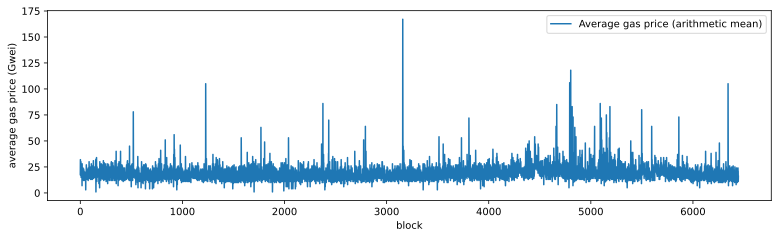

In [ ]:
f2 = plt.figure()
f2.set_figwidth(13)
f2.set_figheight(3.5)
plt.xlabel("block")
plt.ylabel("average gas price (Gwei)")
plt.plot(mean, label = "Average gas price (arithmetic mean)")
# plt.plot(median, label = "median")
plt.legend()
plt.savefig('../results/exp1_2.pdf')
